<h1>Standards</h1>

Trying to find all the peaks in the standard list and plotting their motifs..

In [93]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
basedir = '../'
sys.path.append(basedir)

import numpy as np
import pandas as pd
import networkx as nx
import pylab as plt

import matplotlib as mpl
import matplotlib.cm as cm

from IPython.display import display
from lda_for_fragments import Ms2Lda
from visualisation.networkx.lda_visualisation import *

# get rid of annoying warnings
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<h2>1. Load Data and apply thresholding</h2>

Load Beer3pos project used by Justin and apply thresholding below.

In [2]:
ms2lda = Ms2Lda.resume_from('results/Manuscript_Beer3POSmode_EFassigner_ALLextended.project')

Project loaded from results/Manuscript_Beer3POSmode_EFassigner_ALLextended.project time taken = 20.0317308903
 - input_filenames = 
	../input/manuscript/Beer3pos_MS1filter_Method3_fragments.csv
	../input/manuscript/Beer3pos_MS1filter_Method3_losses.csv
	../input/manuscript/Beer3pos_MS1filter_Method3_ms1.csv
	../input/manuscript/Beer3pos_MS1filter_Method3_ms2.csv
 - df.shape = (1422, 4496)
 - K = 300
 - alpha = 0.166666666667
 - beta = 0.1
 - number of samples stored = 1
 - last_saved_timestamp = 11/30/15 16:11:30
 - message = Beer3Pos analysis for the manuscript with EFassigner EF assignments for ms1, fragments, and losses


In [7]:
ms2lda.do_thresholding(th_doc_topic=0.05, th_topic_word=0.01)

<h2>2. Create network graph</h2>

Load the motifs of interest from an external file

In [26]:
import csv
motif_annotation = {}
motif_idx = {}
i = 0
for item in csv.reader(open("results/beer3pos_annotation_Nov2015.csv"), skipinitialspace=True):
    key = int(item[0])
    val = item[1]
    print str(key) + "\t" + val
    motif_annotation[key] = val
    motif_idx[key] = i
    i += 1

motifs_of_interest = motif_annotation.keys()    

# find out which words belong to which M2M
word_map = ms2lda.print_motif_features(selected_motifs=motifs_of_interest, quiet=True)
    
# map each motif to the colourmap too
# http://matplotlib.org/1.2.1/mpl_examples/pylab_examples/show_colormaps.hires.png
norm = mpl.colors.Normalize(vmin=min(motif_idx.values()), vmax=max(motif_idx.values()))
cmap = cm.gist_rainbow
motif_colour = cm.ScalarMappable(norm=norm, cmap=cmap)

2	Small nitrogen containing fragment ion - often proline or ornithine derived
260	Water loss - indicative of a free hydroxyl group
262	Combined loss of H2O and CO, suggests free carboxylic acid group (COOH) substructure
226	Loss of [hexose-H2O] - suggests hexose conjugation (e.g. glucose) substructure
158	Leucine substructure
243	Conjugation of a phosphate group (H4O4P) substructure
127	Conjugation of a phosphate group (H4O4P) substructure
53	Losses indicative of a hexose with NH2 group
98	Fragments possibly indicative for N-Methyl-oxo-pyrrolidinecarboxylic acid like structure
174	Pyroglutamic acid (pyroglutamate) substructure
59	Pyroglutamic acid (pyroglutamate) substructure
214	Amine loss - suggests free NH2 group in fragmented molecule
60	Double water loss - indicative for metabolites containing multiple OH groups and aliphatic chain, e.g. as in sugars
151	[proline-H2O] suggests conjugated proline substructure
280	Loss possibly indicative of carboxylic acid group with 1-carbon attac

In [86]:
G = get_network_graph(ms2lda, motifs_of_interest)
print "\n" + nx.info(G)

Removed 256 motifs from the graph because they're not in the list
Removed [] from the graph because they don't share documents with other motifs in the list
Removed 367 unconnected documents from the graph

Name: 
Type: Graph
Number of nodes: 1099
Number of edges: 1708
Average degree:   3.1083


<h2>3. Standard Peaks</h2>

Now we need to find which MS1 peaks match the list of standards. First, load the standard csv.

In [23]:
mode = 'POS' # either 'POS' or 'NEG'

std_peaks = []
with open("results/StandardsCombined_20150422_forJoe.csv", "rb") as infile:
   reader = csv.reader(infile)
   next(reader, None)  # skip the headers
   for row in reader:
    stdmix = int(row[0])
    compound_name = row[1]
    formula = row[2]
    polarity = row[3]
    mz = float(row[4])
    rt = float(row[5]) * 60
    mh_intensity = float(row[6])
    tup = (stdmix, compound_name, formula, polarity, mz, rt, mh_intensity)
    if mode == 'POS' and polarity == '+':
        std_peaks.append(tup)
    elif mode == 'NEG' and polarity == '-':
        std_peaks.append(tup)

for tup in std_peaks:
    print tup

(1, '1-Naphthylacetic acid', 'C12H10O2', '+', 187.07535, 249.60000000000002, 54057.0)
(1, 'Serotonin', 'C10H12N2O', '+', 177.10242, 259.20000000000005, 97472.0)
(1, 'Melatonin', 'C13H16N2O2', '+', 233.12831, 276.0, 642246756.0)
(1, 'Phenylhydrazine', 'C6H8N2', '+', 109.07608, 301.8, 5947432.0)
(1, 'Nicotinate', 'C6H5NO2', '+', 124.03932, 412.2, 761863744.0)
(1, 'Pyridoxine', 'C8H11NO3', '+', 170.0811, 435.59999999999997, 1744299213.0)
(1, 'riboflavin', 'C17H20N4O6', '+', 377.14548, 452.4, 9255138.0)
(1, 'Glycerol', 'C3H8O3', '+', 93.05468, 480.0, 2873527.0)
(1, 'Adenine', 'C5H5N5', '+', 136.06174, 491.99999999999994, 167402201.0)
(1, 'Creatinine', 'C4H7N3O', '+', 114.06613, 496.79999999999995, 1055015474.0)
(1, 'L-Phenylalanine', 'C9H11NO2', '+', 166.0862, 499.8, 54983812.0)
(1, 'L-Leucine', 'C6H13NO2', '+', 132.10185, 520.8, 178751219.0)
(1, '4-Aminobenzoate', 'C7H7NO2', '+', 138.05498, 511.2, 21075822.0)
(1, 'Inosine', 'C10H12N4O5', '+', 269.08783, 528.0, 59555340.0)
(1, '2-Phenylgly

Find out the peak ids in our MS1 dataframe that match these standards

In [87]:
import math

mass_tol = 3
rt_tol = 12

std = np.array(std_peaks)
std_mz = np.array([x[4] for x in std_peaks])
std_rt = np.array([x[5] for x in std_peaks])
matches = {}

ms1_label = {}
for row in ms2lda.ms1.itertuples(index=True):
    peakid = row[1]
    mz = row[5]
    rt = row[4]

    # the following line is hacky for pos mode data
    mass_delta = mz*mass_tol*1e-6
    mass_start = mz-mass_delta
    mass_end = mz+mass_delta
    rt_start = rt-rt_tol
    rt_end = rt+rt_tol

    match_mass = (std_mz>mass_start) & (std_mz<mass_end)
    match_rt = (std_rt>rt_start) & (std_rt<rt_end)
    match = match_mass & match_rt

    res = std[match]
    if len(res) == 1:
        closest = tuple(res[0])
        matches[closest] = row
        ms1_label[row[1]] = closest[1]        
    elif len(res)>1:
        closest = None
        min_dist = sys.maxint
        for match_res in res:
            match_mz = float(match_res[4])
            match_rt = float(match_res[5])
            dist = math.sqrt((match_rt-rt)**2 + (match_mz-mz)**2)
            if dist < min_dist:
                min_dist = dist
                closest = match_res
        closest = tuple(closest)
        matches[closest] = row
        ms1_label[row[1]] = closest[1]

print "Matches found %d/%d" % (len(matches), len(std))
print

ms1_list = []
for match in matches:
    key = str(match)
    ms1_row = matches[match]
    value = str(ms1_row)
    pid = ms1_row[1]
    print "Standard %s" % key
    print "MS1 %s" % value
    print
    ms1_list.append(pid)

Matches found 45/117

Standard ('3', 'O-Acetylcarnitine', 'C9H17NO4', '+', '204.12289', '520.2', '2530268729.0')
MS1 Pandas(Index=10237, peakID=10237, MSnParentPeakID=0, msLevel=1, rt=518.50300000000004, mz=204.12305134669299, intensity=2407559.25, Sample=1, GroupPeakMSn=0, CollisionEnergy=0, annotation='C9H18O4N')

Standard ('2', 'L-homoserine', 'C4H9NO3', '+', '120.06561', '637.8', '91565828.0')
MS1 Pandas(Index=1003, peakID=1003, MSnParentPeakID=0, msLevel=1, rt=633.80399999999997, mz=120.065513905275, intensity=5077896.0, Sample=1, GroupPeakMSn=0, CollisionEnergy=0, annotation='C4H10O3N')

Standard ('2', '5-Oxoproline', 'C5H7NO3', '+', '130.04996', '491.4', '210756304.0')
MS1 Pandas(Index=1795, peakID=1795, MSnParentPeakID=0, msLevel=1, rt=484.00199999999995, mz=130.04989405333401, intensity=247324512.0, Sample=1, GroupPeakMSn=0, CollisionEnergy=0, annotation='C5H8O3N')

Standard ('3', 'O-Acetyl-L-serine', 'C5H9NO4', '+', '148.06027', '586.8', '34229806.0')
MS1 Pandas(Index=3970, p

MS1 peakID 10237 mz 204.1231 rt 518.50 intensity 2407559.25 (C9H18O4N; O-Acetylcarnitine)
 - M2M_131	: fragments from [hexose-H2O] substructure (a hexose conjugation, e.g. glucose)



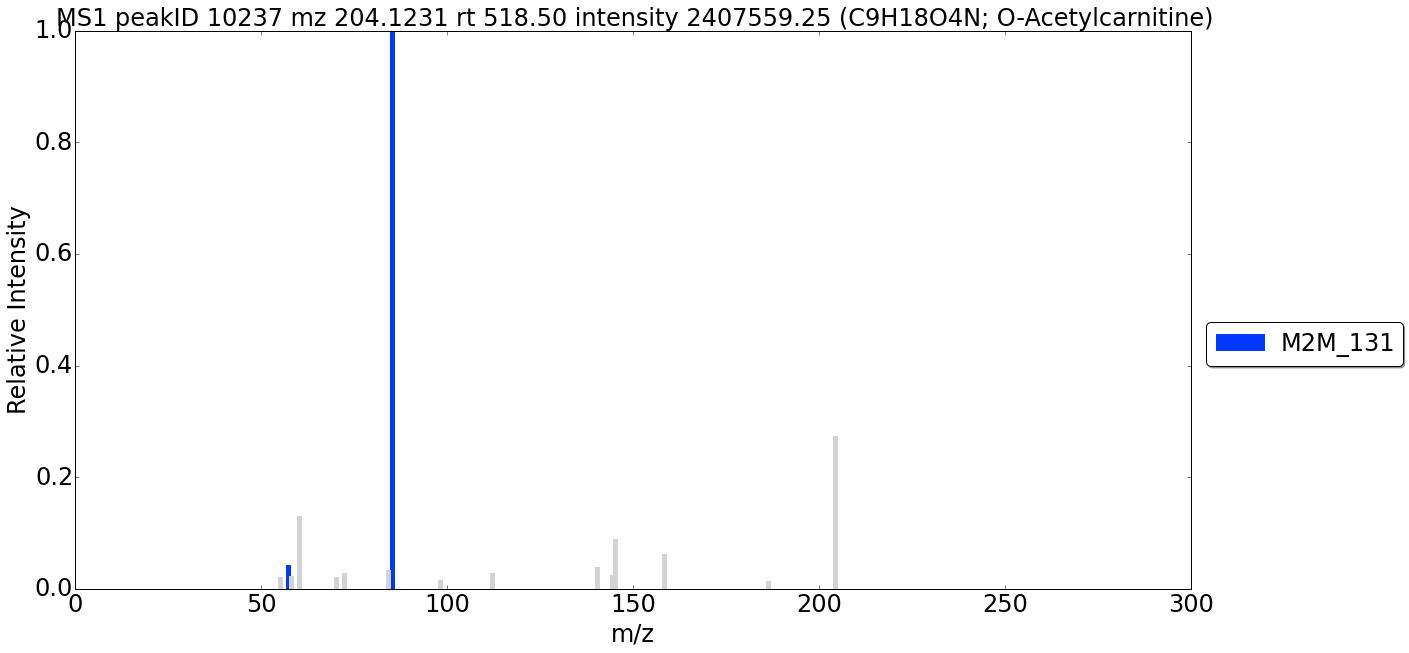

MS1 peakID 1003 mz 120.0655 rt 633.80 intensity 5077896.00 (C4H10O3N; L-homoserine)
 - M2M_262	: Combined loss of H2O and CO, suggests free carboxylic acid group (COOH) substructure



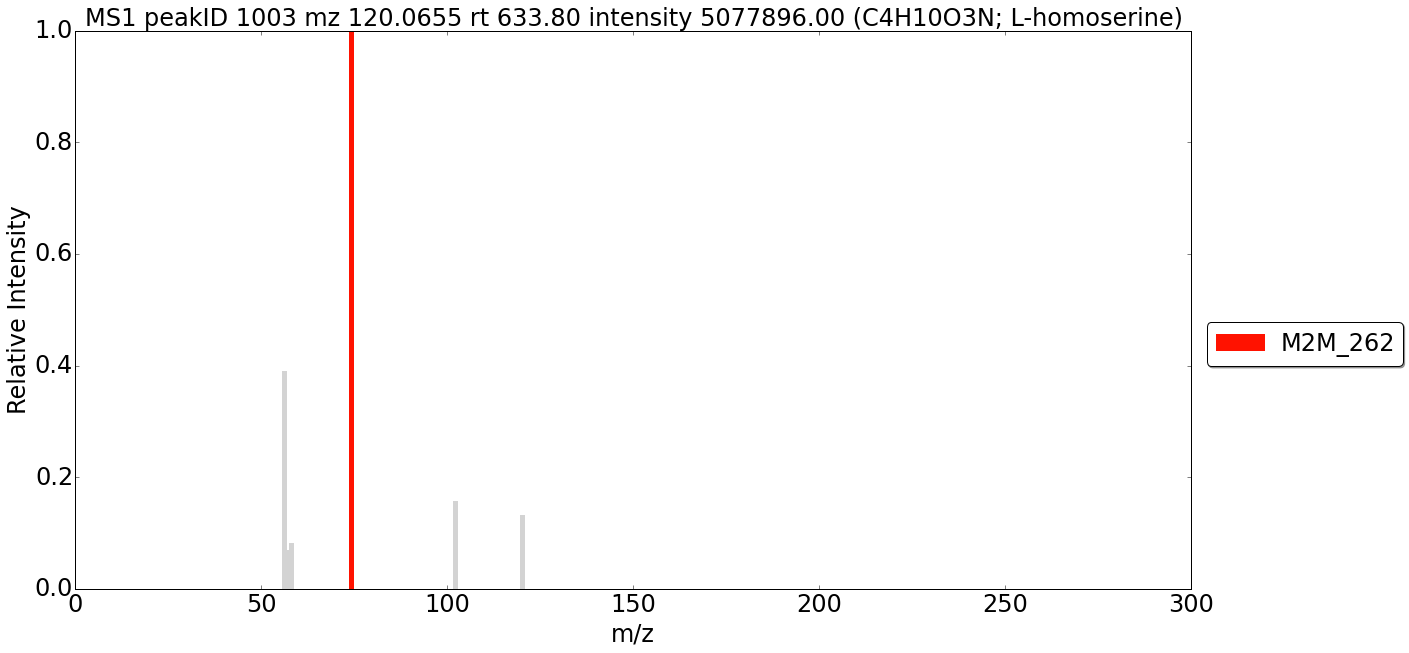

MS1 peakID 1795 mz 130.0499 rt 484.00 intensity 247324512.00 (C5H8O3N; 5-Oxoproline)
 - M2M_174	: Pyroglutamic acid (pyroglutamate) substructure
 - M2M_262	: Combined loss of H2O and CO, suggests free carboxylic acid group (COOH) substructure



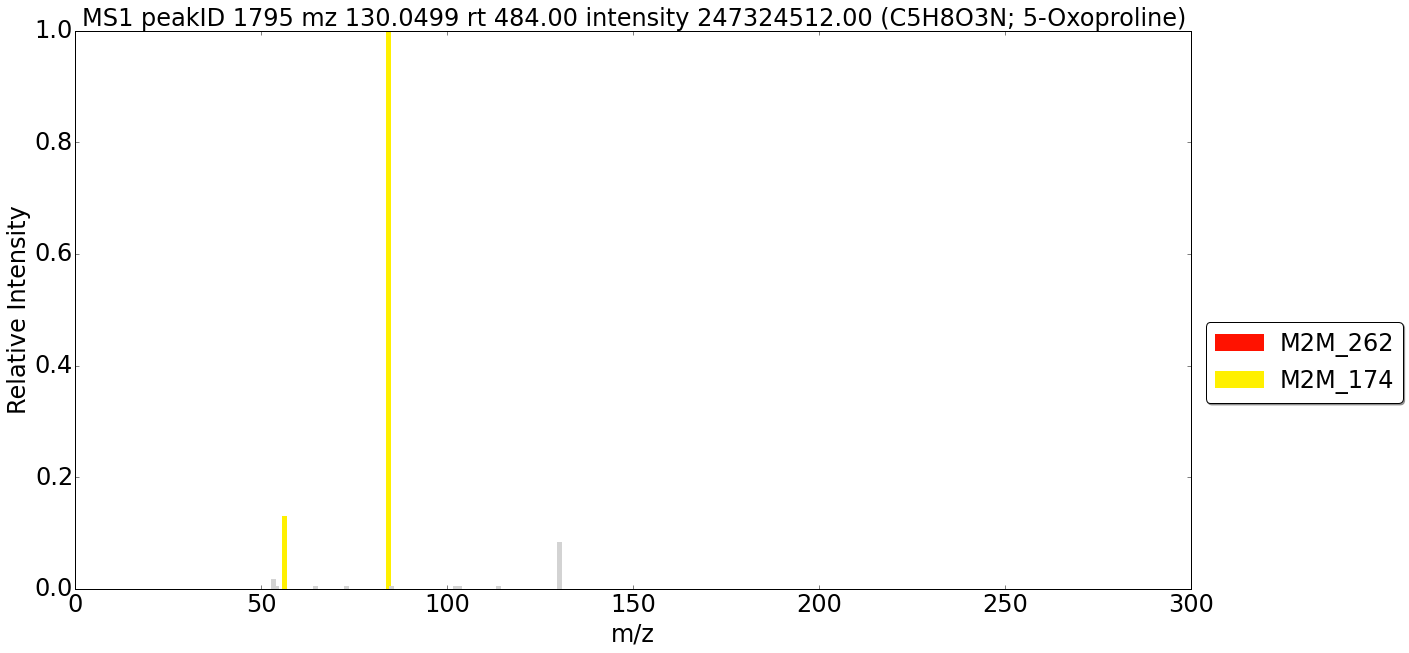

MS1 peakID 3970 mz 148.0603 rt 598.47 intensity 6657020.00 (C5H10O4N; O-Acetyl-L-serine)
 - M2M_174	: Pyroglutamic acid (pyroglutamate) substructure



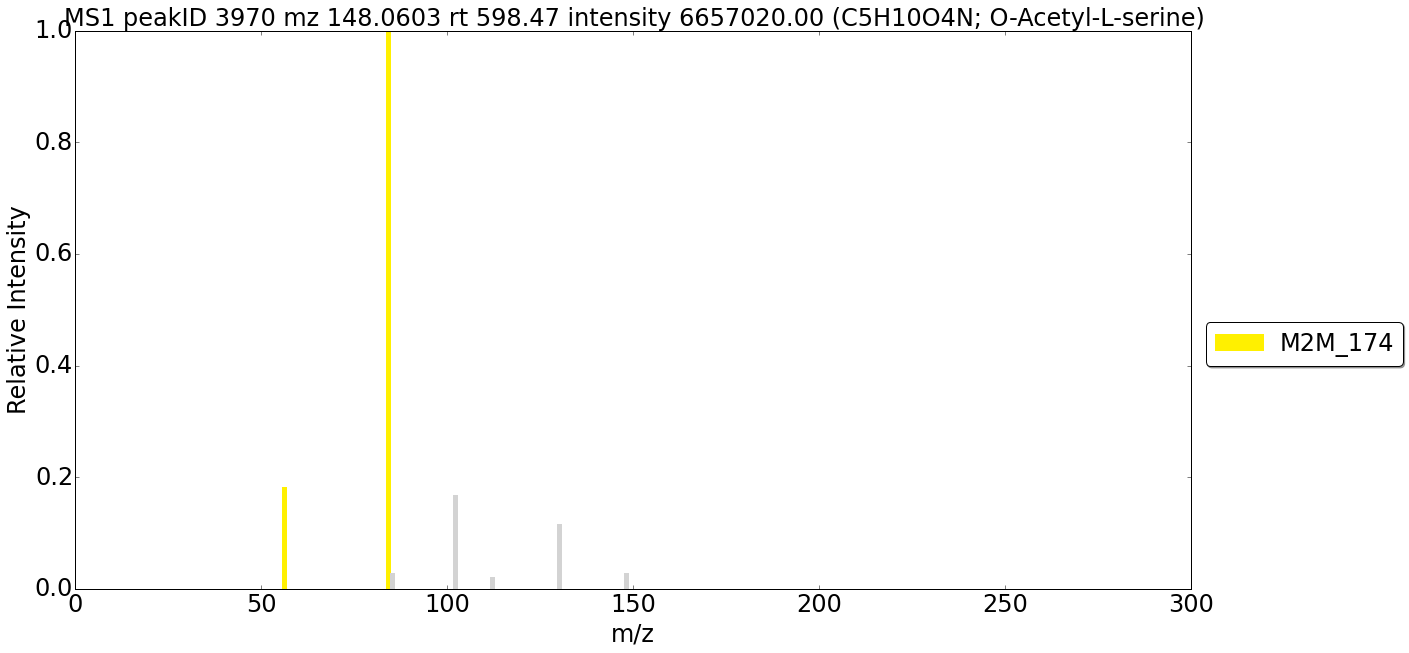

MS1 peakID 6289 mz 170.0811 rt 433.35 intensity 38320380.00 (C8H12O3N; Pyridoxine)
 - M2M_260	: Water loss - indicative of a free hydroxyl group
 - M2M_60	: Double water loss - indicative for metabolites containing multiple OH groups and aliphatic chain, e.g. as in sugars



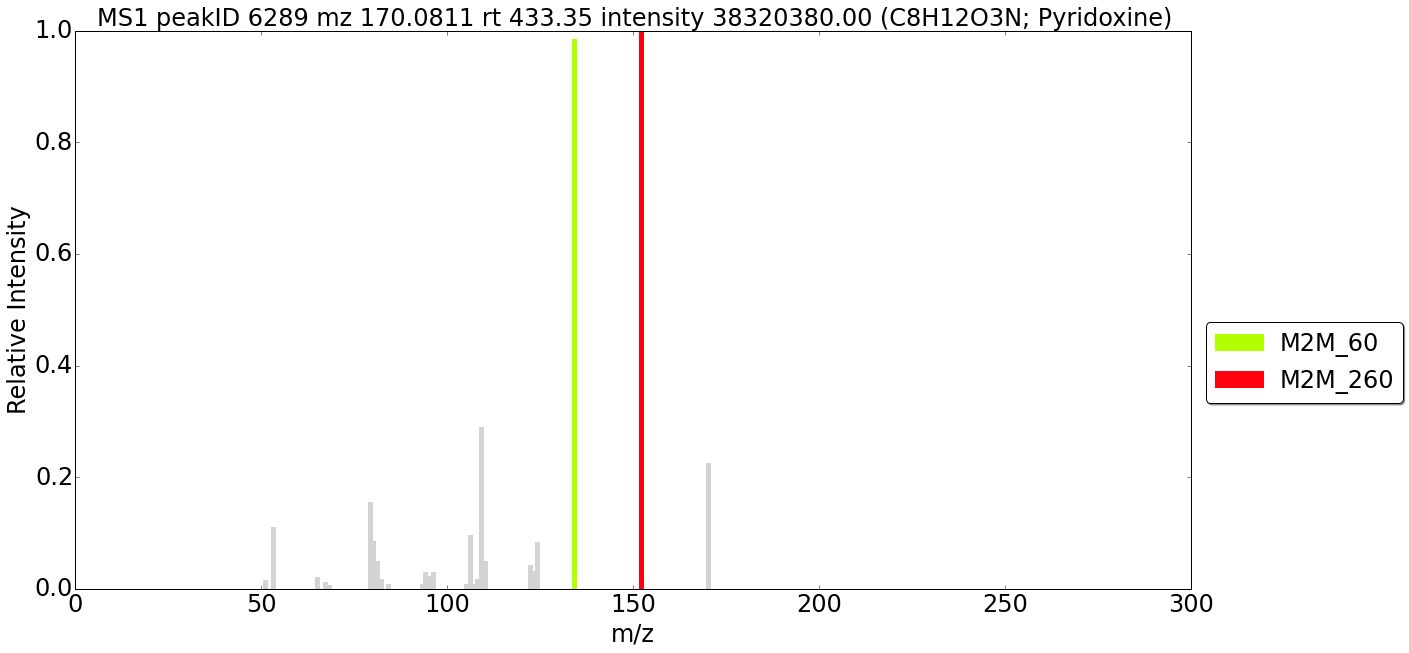

MS1 peakID 6319 mz 170.0924 rt 558.50 intensity 3766961.75 (C7H12O2N3; N(pi)-Methyl-L-histidine)
 - M2M_40	: Imidazole group linked to a carboxylgroup through one CH2 group substructure
 - M2M_262	: Combined loss of H2O and CO, suggests free carboxylic acid group (COOH) substructure



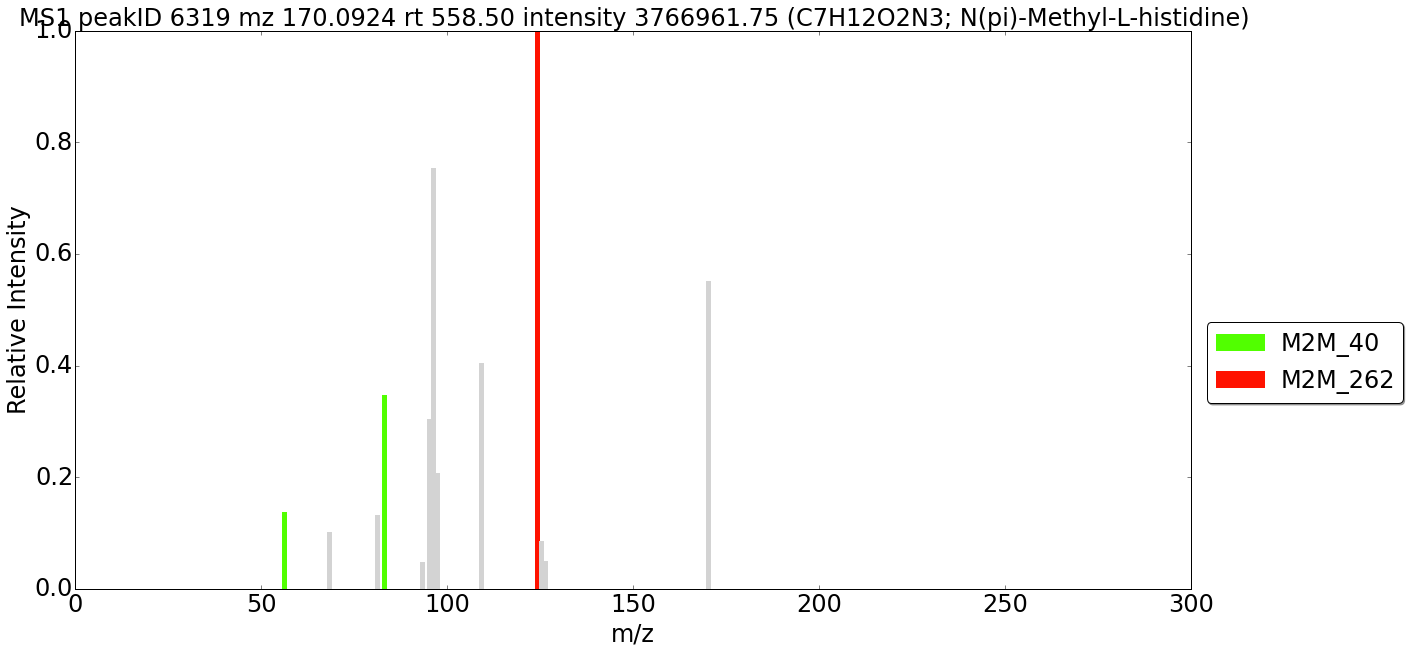

MS1 peakID 4121 mz 150.0774 rt 437.17 intensity 15326802.00 (C6H8N5; 6-Methylaminopurine)
 - No M2M for this MS1 peak at the specified thresholding levels

MS1 peakID 5456 mz 162.1124 rt 582.25 intensity 7117894.00 (C7H16O3N; L-Carnitine)
 - M2M_131	: fragments from [hexose-H2O] substructure (a hexose conjugation, e.g. glucose)



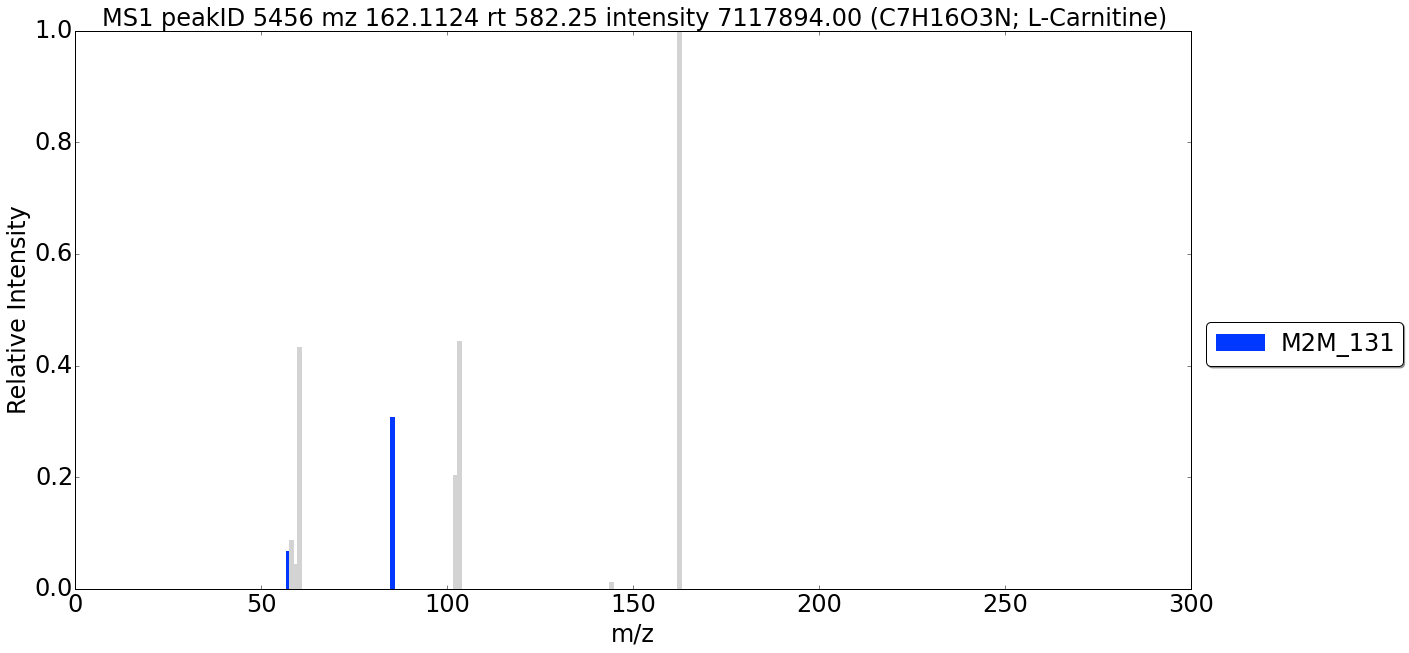

MS1 peakID 6001 mz 166.0863 rt 499.24 intensity 15979306.00 (C9H12O2N; L-Phenylalanine)
 - M2M_115	: [phenylalanine-COOH] substructure
 - M2M_262	: Combined loss of H2O and CO, suggests free carboxylic acid group (COOH) substructure



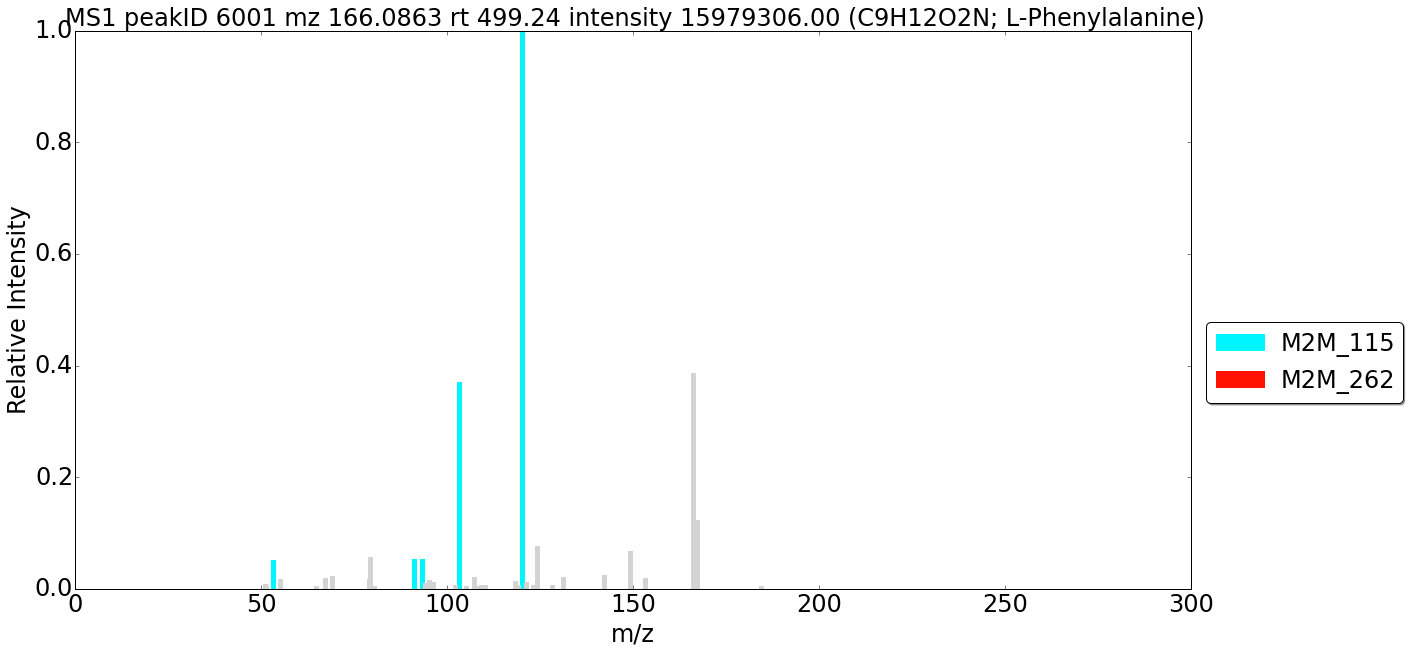

MS1 peakID 3912 mz 147.1127 rt 933.27 intensity 1298433.75 (C6H15O2N2; L-Lysine)
 - M2M_45	: Pipecolic acid (pipecolate) substructure



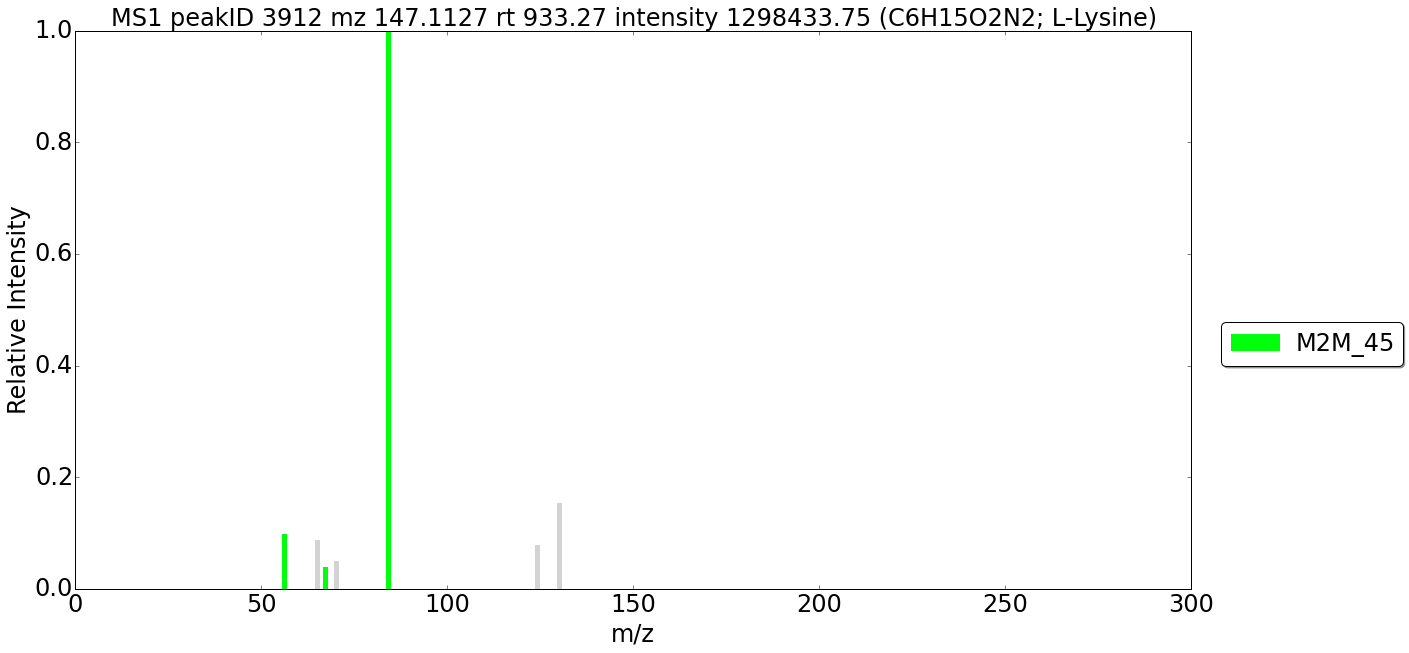

MS1 peakID 2566 mz 134.0447 rt 614.62 intensity 1106318.88 (C4H8O4N; L-Aspartate)
 - M2M_280	: Loss possibly indicative of carboxylic acid group with 1-carbon attached
 - M2M_42	: Asparagine substructure
 - M2M_262	: Combined loss of H2O and CO, suggests free carboxylic acid group (COOH) substructure



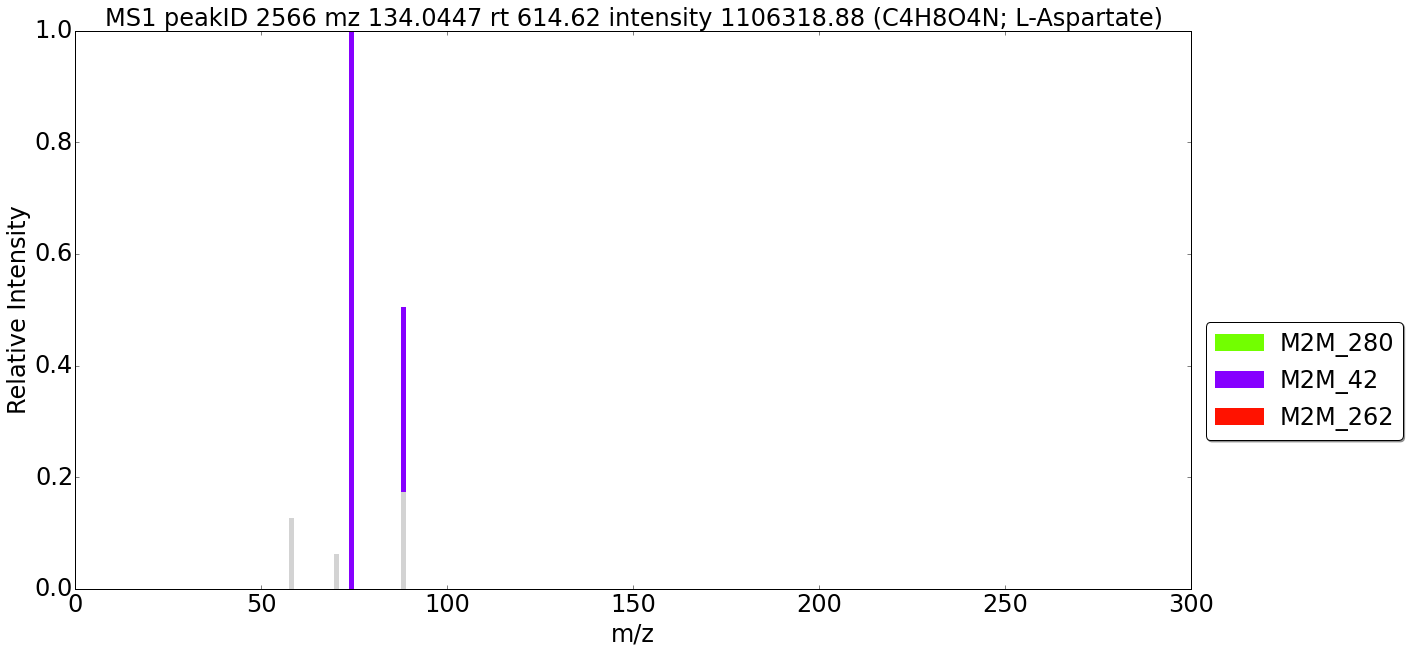

MS1 peakID 131 mz 90.0549 rt 645.03 intensity 2888840.50 (C3H8O2N; beta-Alanine)
 - M2M_260	: Water loss - indicative of a free hydroxyl group



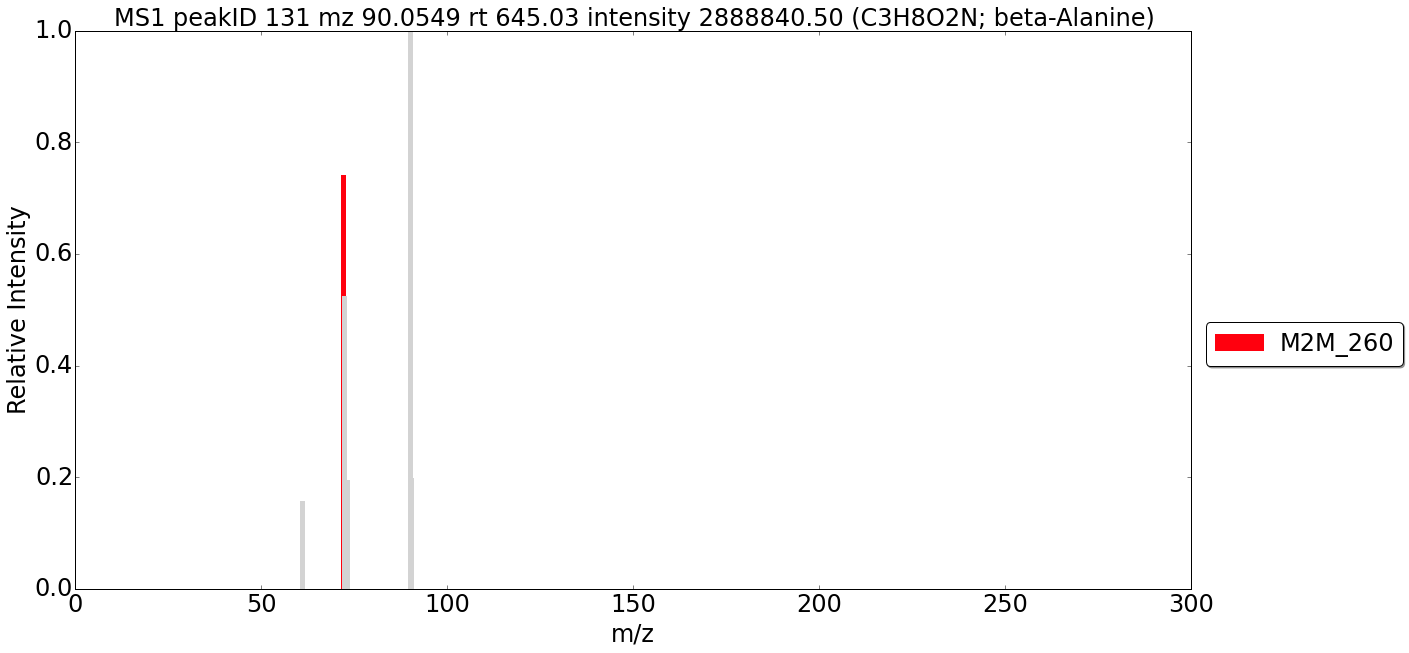

MS1 peakID 4307 mz 152.0567 rt 588.46 intensity 165917856.00 (C5H14NS2; Guanine)
 - M2M_162	: Xanthine substructure
 - M2M_214	: Amine loss - suggests free NH2 group in fragmented molecule



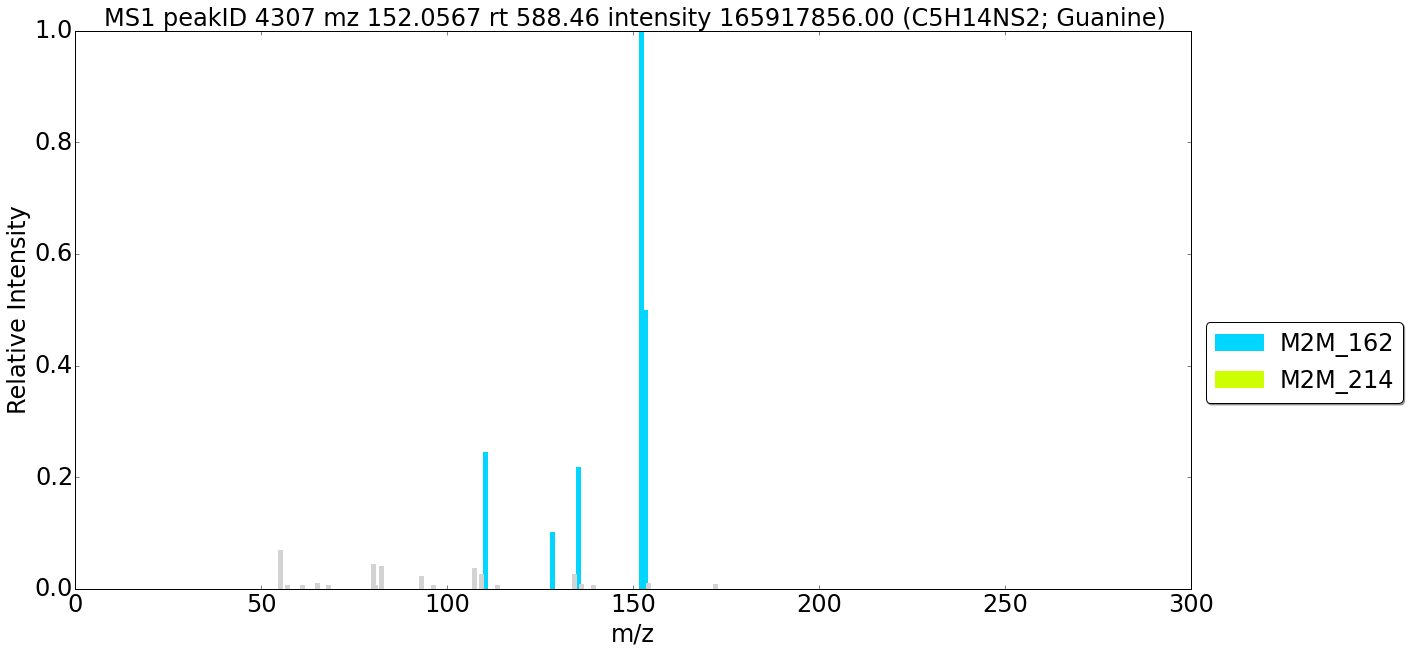

MS1 peakID 7005 mz 175.1189 rt 1002.67 intensity 42606024.00 (C6H15O2N4; L-Arginine)
 - M2M_2	: Small nitrogen containing fragment ion - often proline or ornithine derived
 - M2M_151	: [proline-H2O] suggests conjugated proline substructure



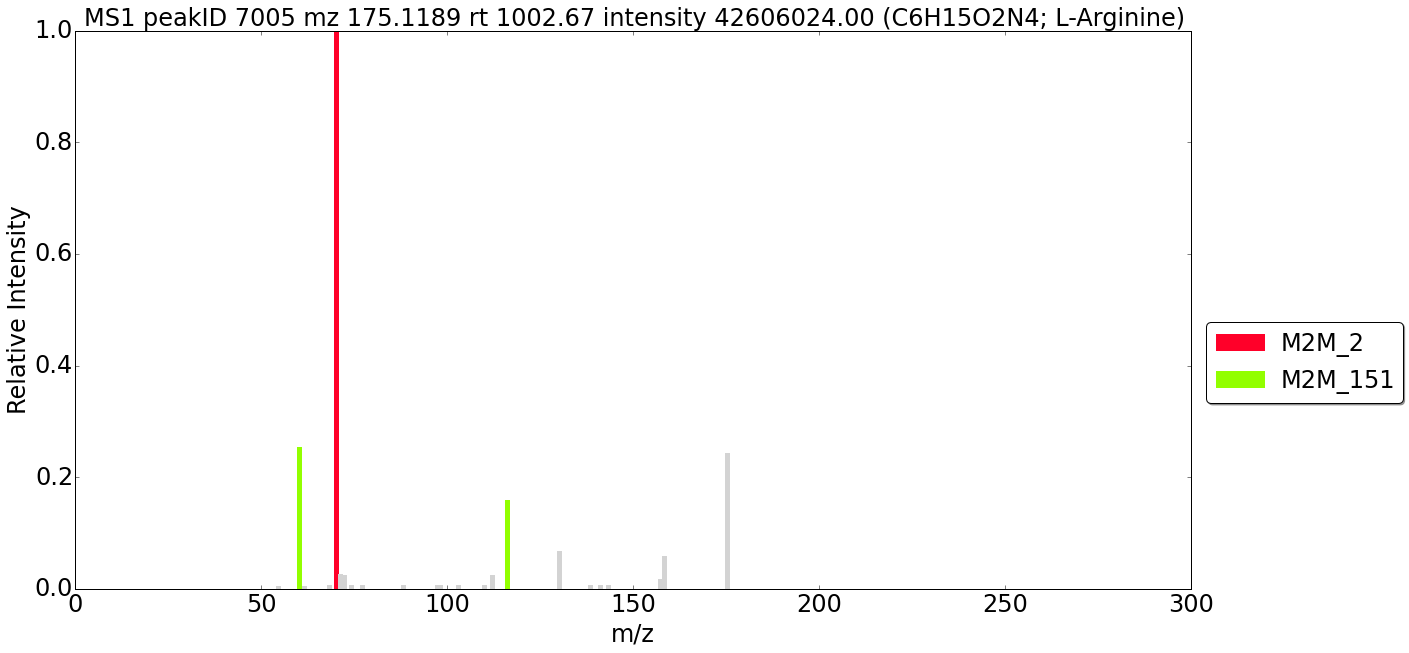

MS1 peakID 10364 mz 205.0972 rt 553.53 intensity 36771424.00 (C11H13O2N2; L-Tryptophan)
 - M2M_202	: Tryptophan related substructure
 - M2M_211	: N-acetylputrescine substructure
 - M2M_214	: Amine loss - suggests free NH2 group in fragmented molecule



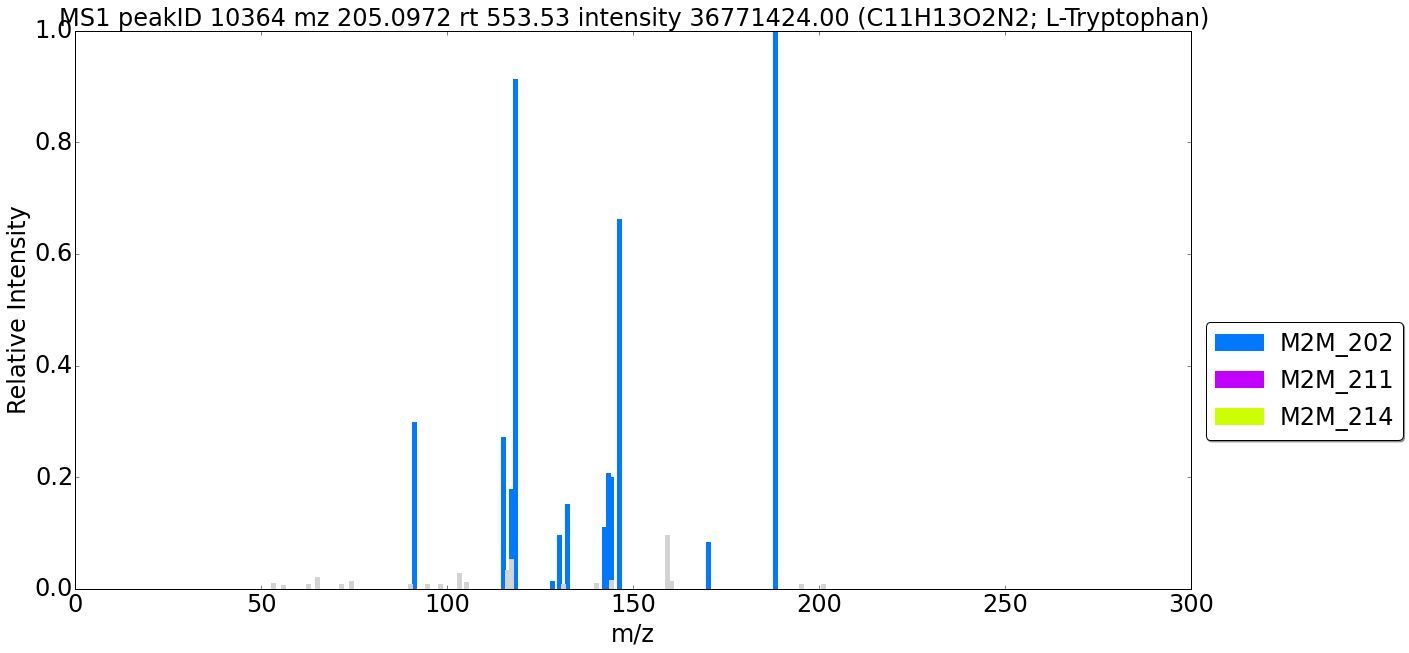

MS1 peakID 21533 mz 284.0988 rt 582.25 intensity 4361483.50 (C9H18O9N; Guanosine)
 - M2M_162	: Xanthine substructure
 - M2M_156	: [Pentose-H2O] loss, e.g. ribose



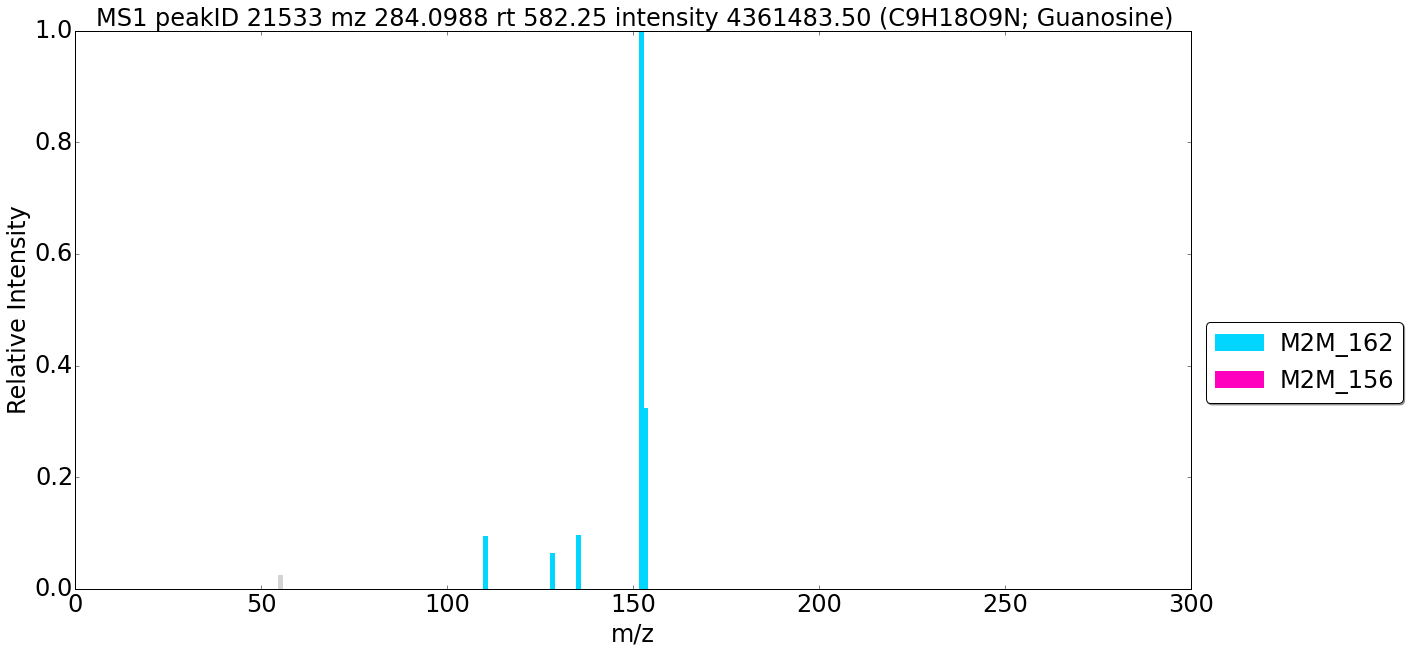

MS1 peakID 12206 mz 220.1179 rt 433.35 intensity 4474088.00 (C9H18O5N; Pantothenate)
 - No M2M for this MS1 peak at the specified thresholding levels

MS1 peakID 3808 mz 147.0764 rt 628.82 intensity 28795256.00 (C5H11O3N2; L-Glutamine)
 - M2M_174	: Pyroglutamic acid (pyroglutamate) substructure
 - M2M_214	: Amine loss - suggests free NH2 group in fragmented molecule



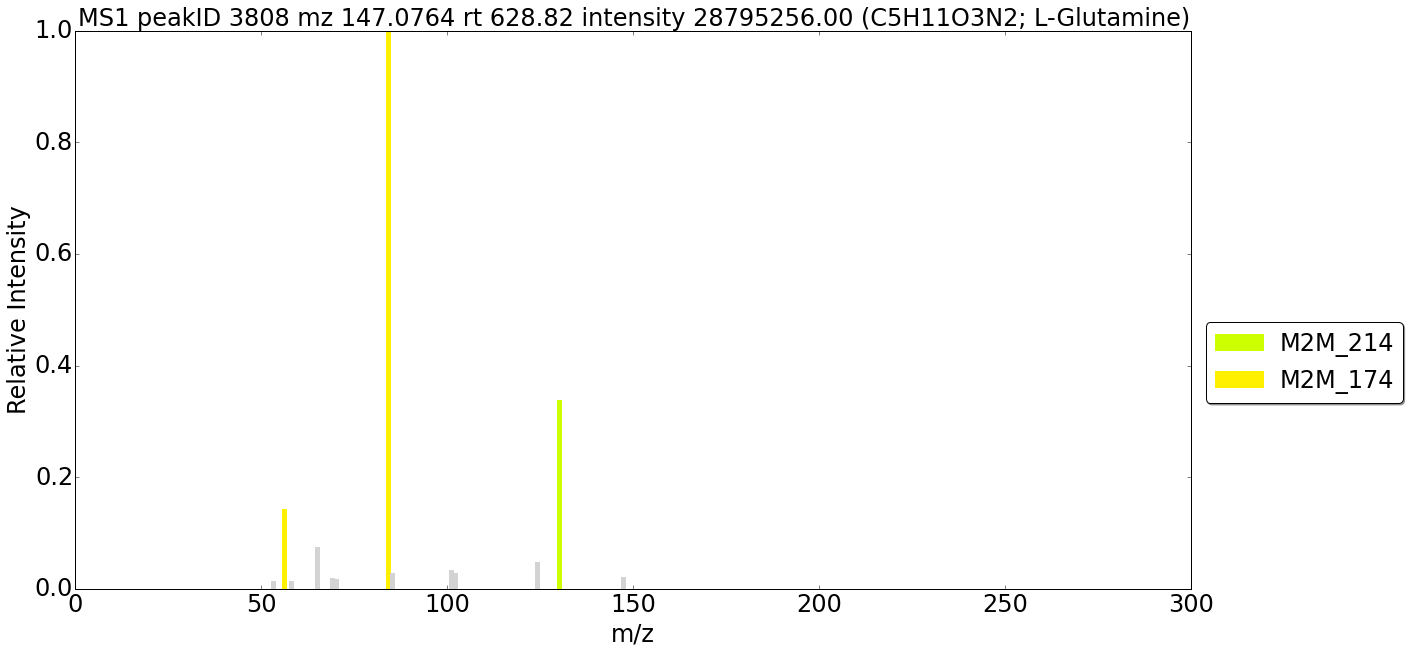

MS1 peakID 2538 mz 133.0971 rt 874.87 intensity 31991762.00 (C5H13O2N2; L-Ornithine)
 - M2M_2	: Small nitrogen containing fragment ion - often proline or ornithine derived
 - M2M_214	: Amine loss - suggests free NH2 group in fragmented molecule
 - M2M_151	: [proline-H2O] suggests conjugated proline substructure



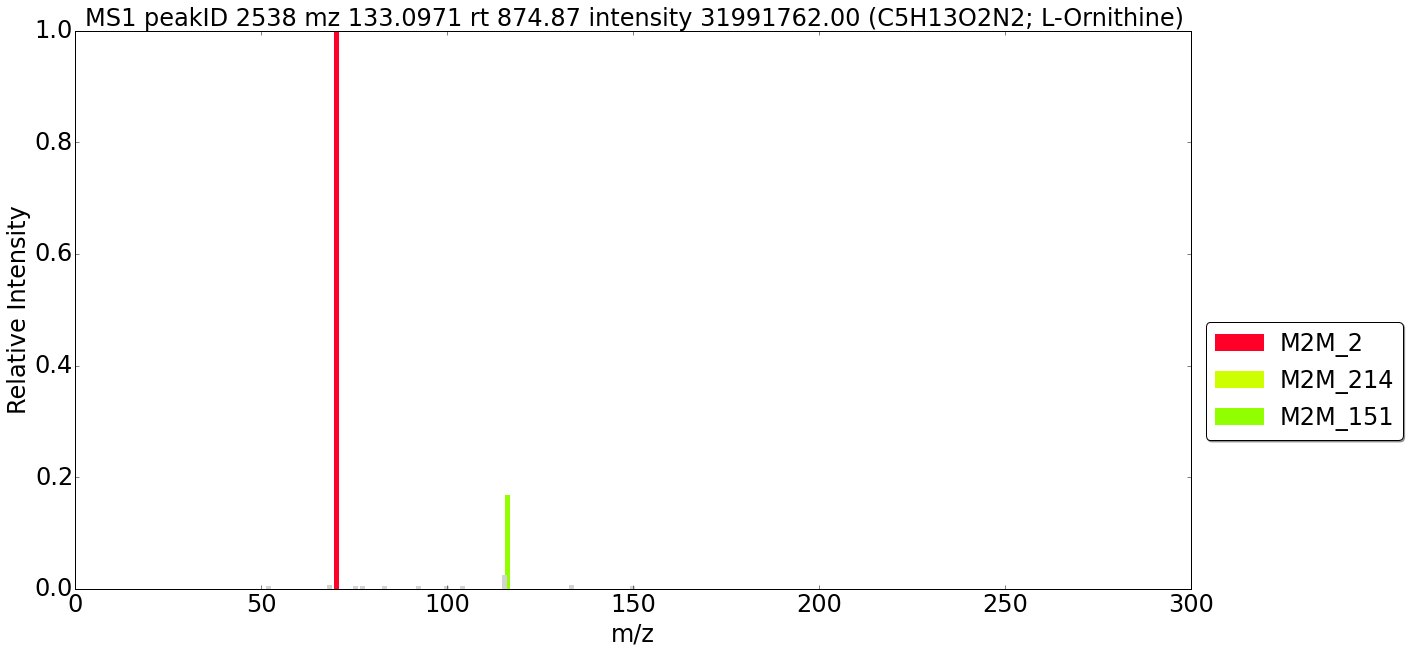

MS1 peakID 2403 mz 132.1019 rt 519.74 intensity 28418200.00 (C6H14O2N; L-Leucine)
 - M2M_158	: Leucine substructure
 - M2M_262	: Combined loss of H2O and CO, suggests free carboxylic acid group (COOH) substructure



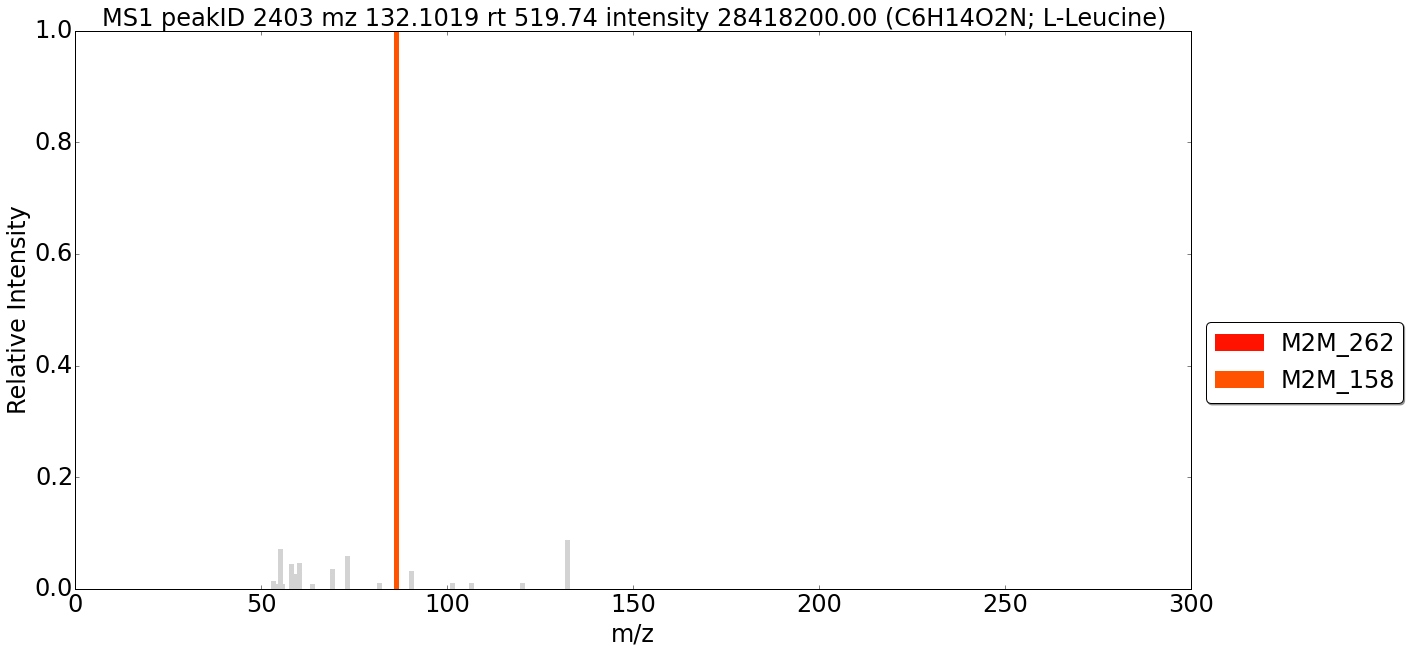

MS1 peakID 12421 mz 223.0746 rt 668.85 intensity 547783.81 (C9H20PS2; L-Cystathionine)
 - No M2M for this MS1 peak at the specified thresholding levels

MS1 peakID 19 mz 76.0393 rt 656.24 intensity 1047793.69 (C2H6O2N; Glycine)
 - M2M_184	: Trimethylated amine connected to a carboxylic acid group substructure (e.g. betaine)



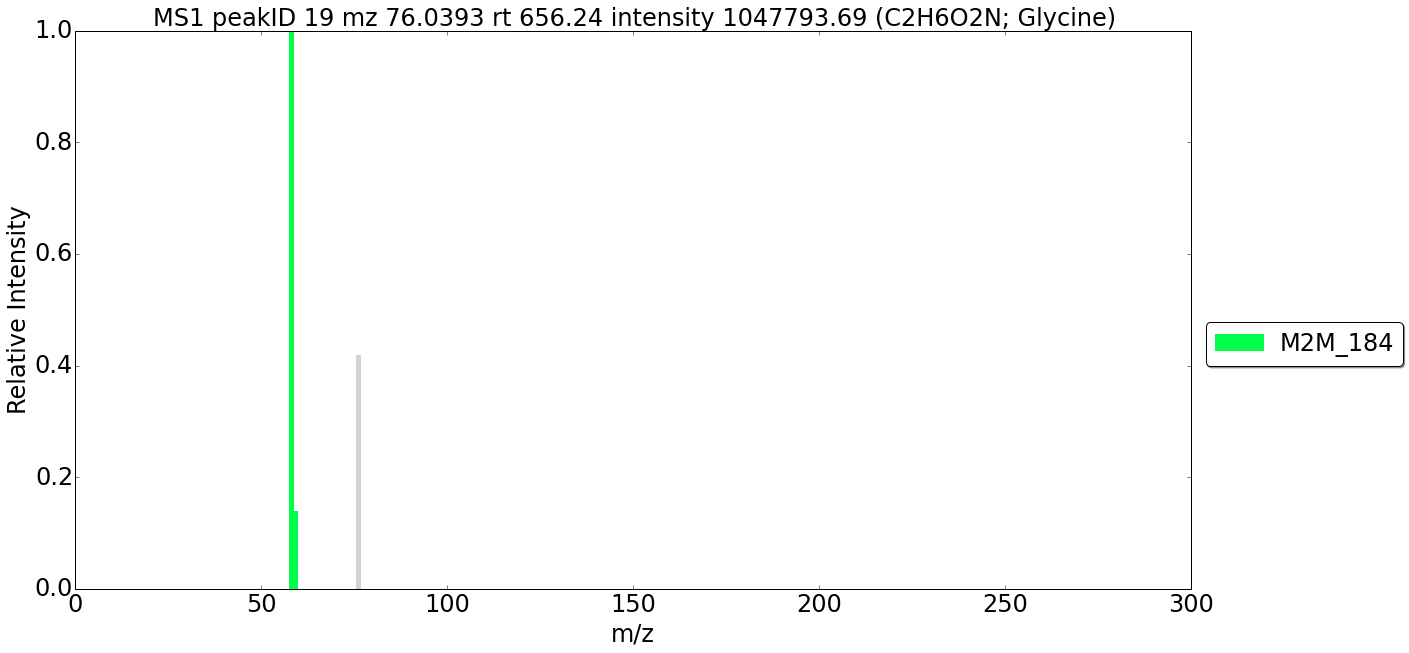

MS1 peakID 4608 mz 154.0974 rt 416.80 intensity 2377199.00 (C7H12ON3; 4-(beta-Acetylaminoethyl)imidazole)
 - M2M_17	: Tyrosine substructure
 - M2M_91	: Aromatic substructure, i.e., benzene ring with hydroxyl and amine substitution



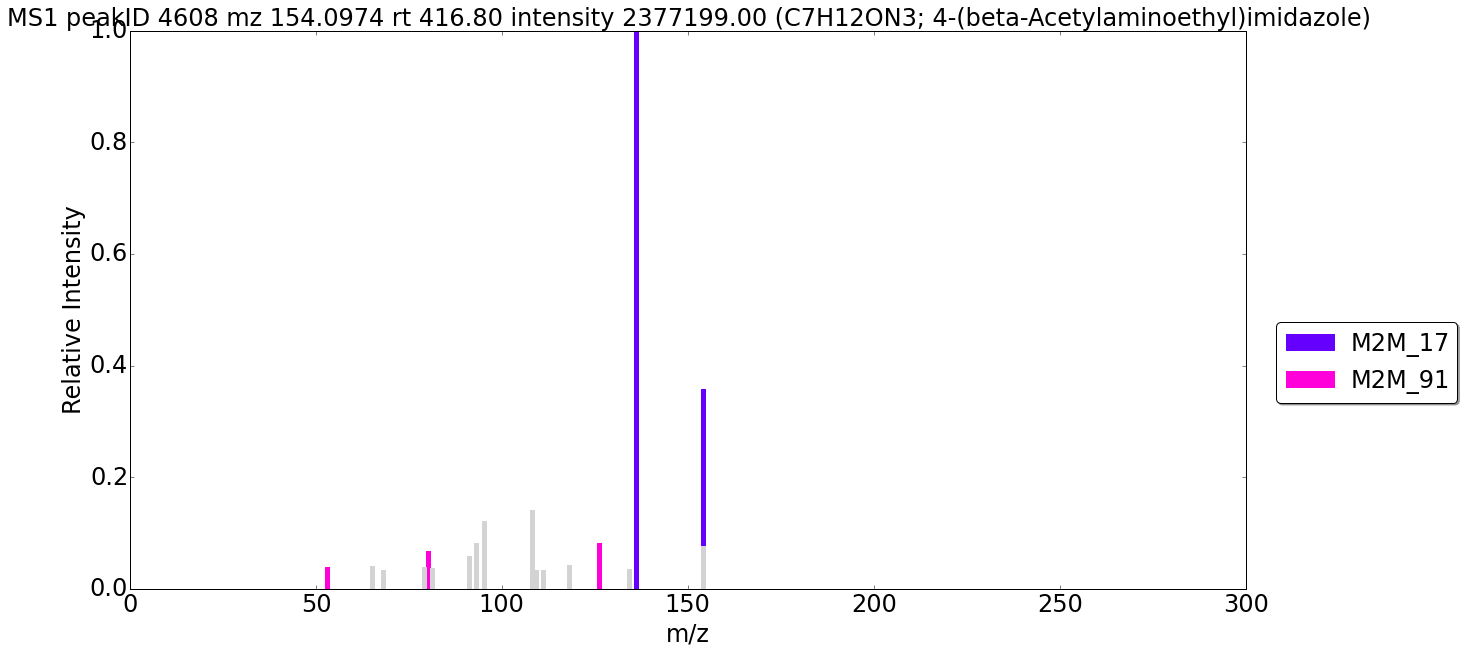

MS1 peakID 18872 mz 268.1039 rt 469.71 intensity 8295168.00 (C9H18O8N; Adenosine)
 - M2M_220	: Adenine substructure
 - M2M_156	: [Pentose-H2O] loss, e.g. ribose



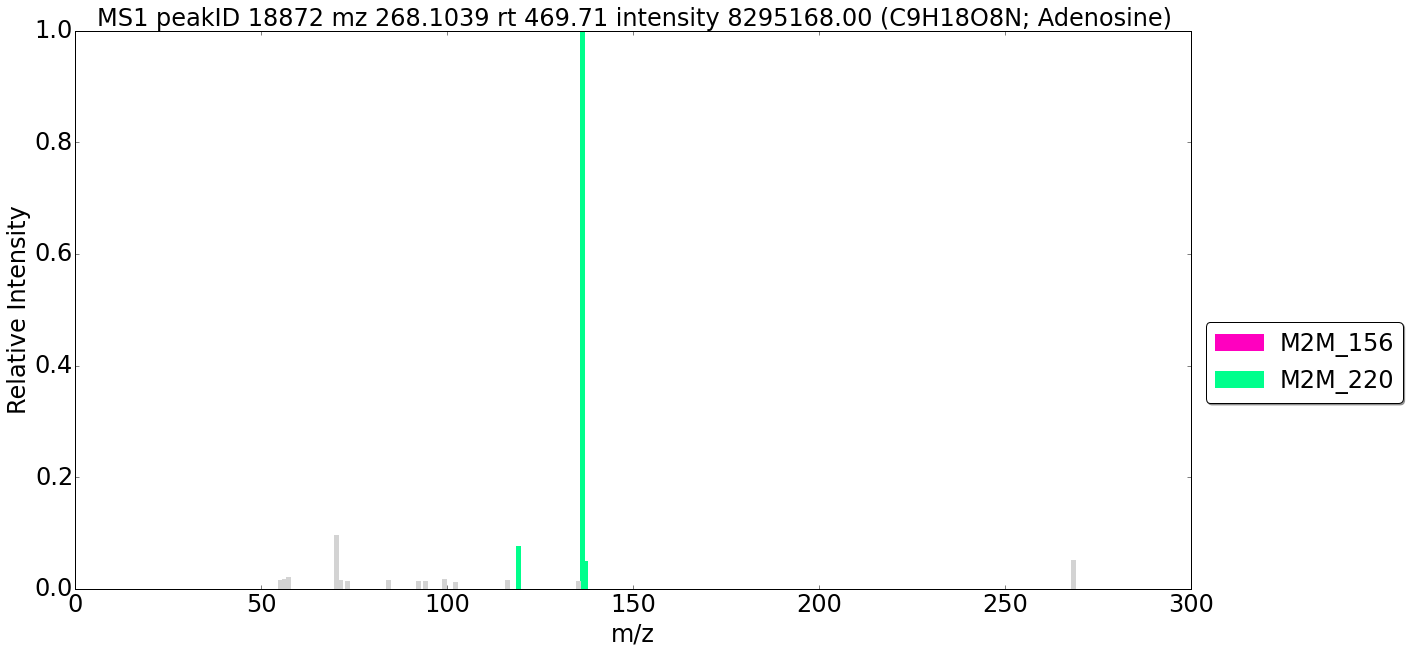

MS1 peakID 141 mz 90.0550 rt 631.31 intensity 6755740.00 (C3H8O2N; L-Alanine)
 - M2M_260	: Water loss - indicative of a free hydroxyl group



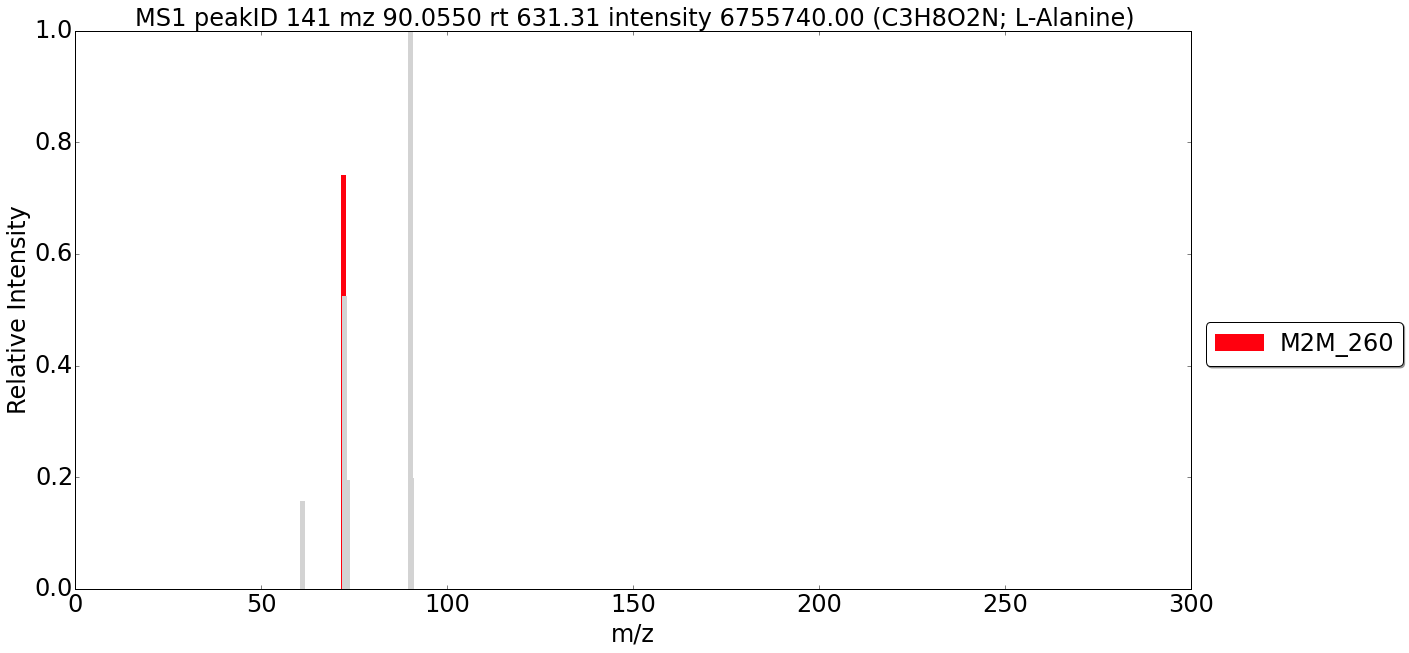

MS1 peakID 15724 mz 244.0928 rt 559.74 intensity 19470474.00 (C11H19ONPS; Cytidine)
 - M2M_130	: Cytosine and a loss of conjugated deoxyribose substructure
 - M2M_156	: [Pentose-H2O] loss, e.g. ribose



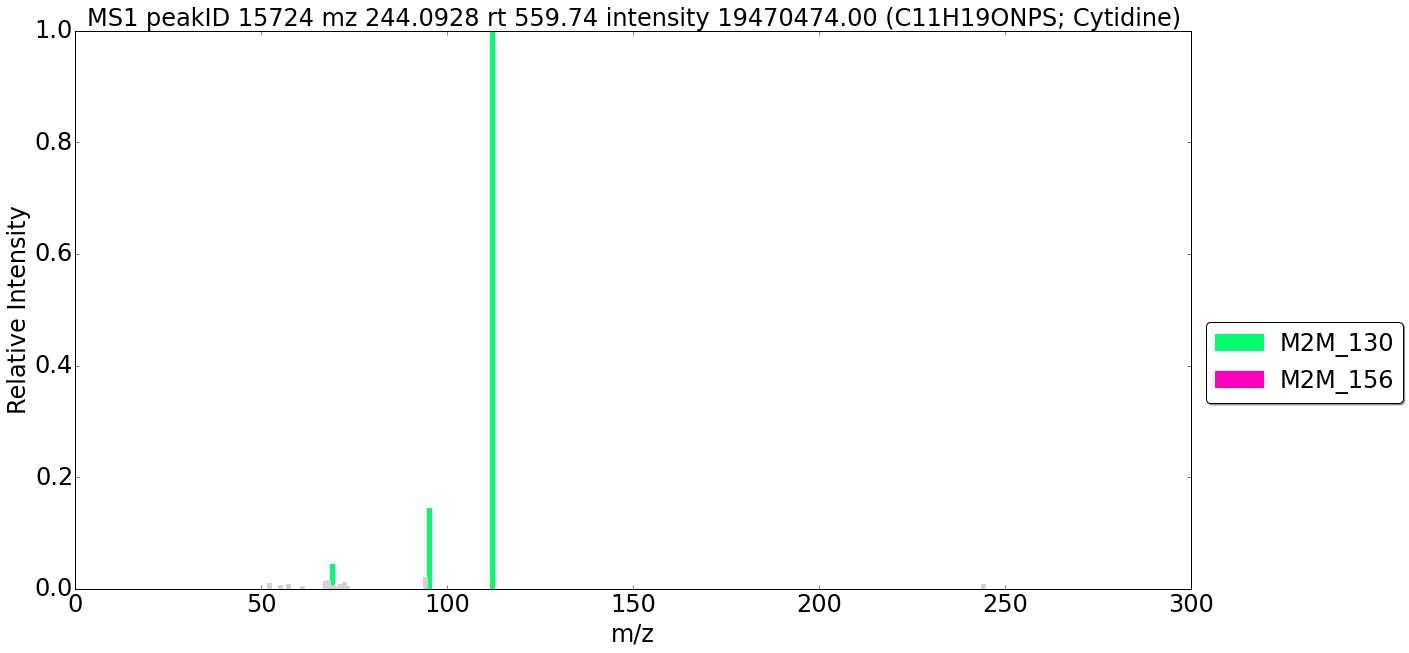

MS1 peakID 1174 mz 123.0552 rt 411.62 intensity 11639933.00 (C6H7ON2; Nicotinamide)
 - No M2M for this MS1 peak at the specified thresholding levels

MS1 peakID 288 mz 104.0705 rt 646.27 intensity 118432208.00 (C4H10O2N; 4-Aminobutanoate)
 - M2M_214	: Amine loss - suggests free NH2 group in fragmented molecule
 - M2M_260	: Water loss - indicative of a free hydroxyl group
 - M2M_69	: Possibly suggests 2-OH-4-oxo-pentanoic acid substructure
 - M2M_230	: N/O-acetylation loss



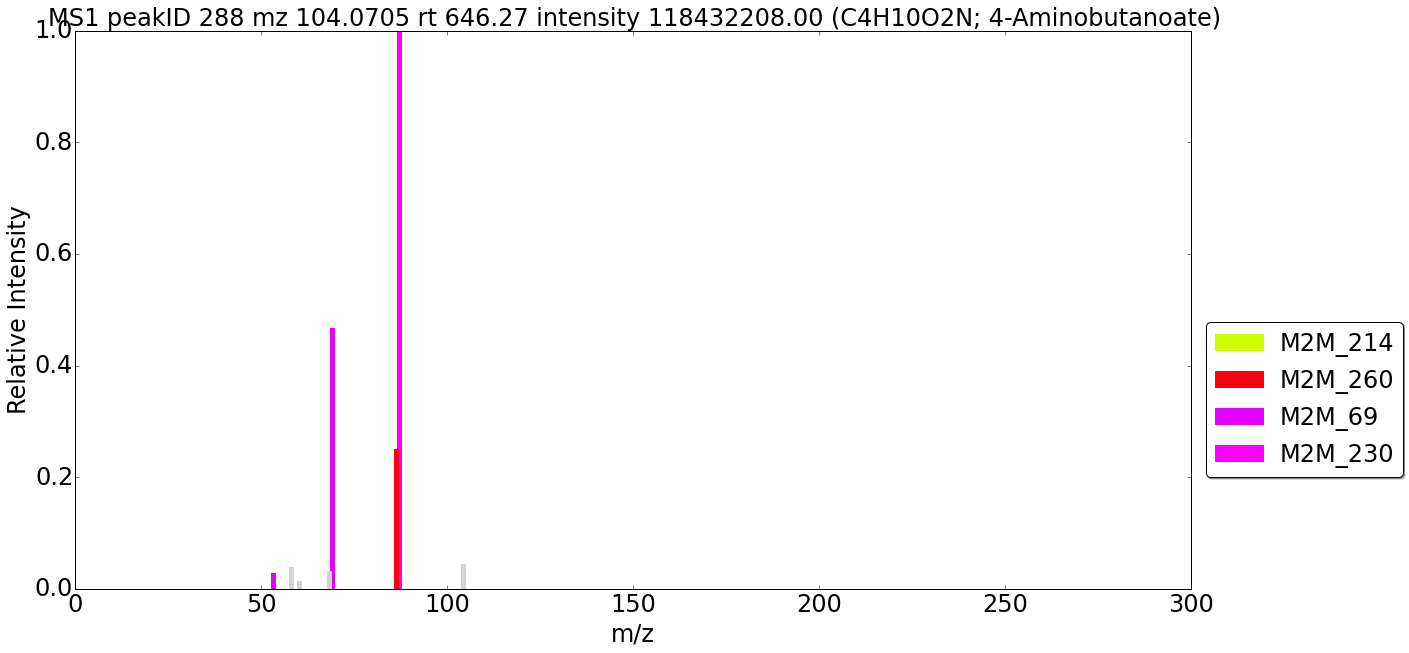

MS1 peakID 4779 mz 156.0768 rt 621.07 intensity 110043960.00 (C6H10O2N3; L-Histidine)
 - M2M_241	: Histidine substructure
 - M2M_262	: Combined loss of H2O and CO, suggests free carboxylic acid group (COOH) substructure



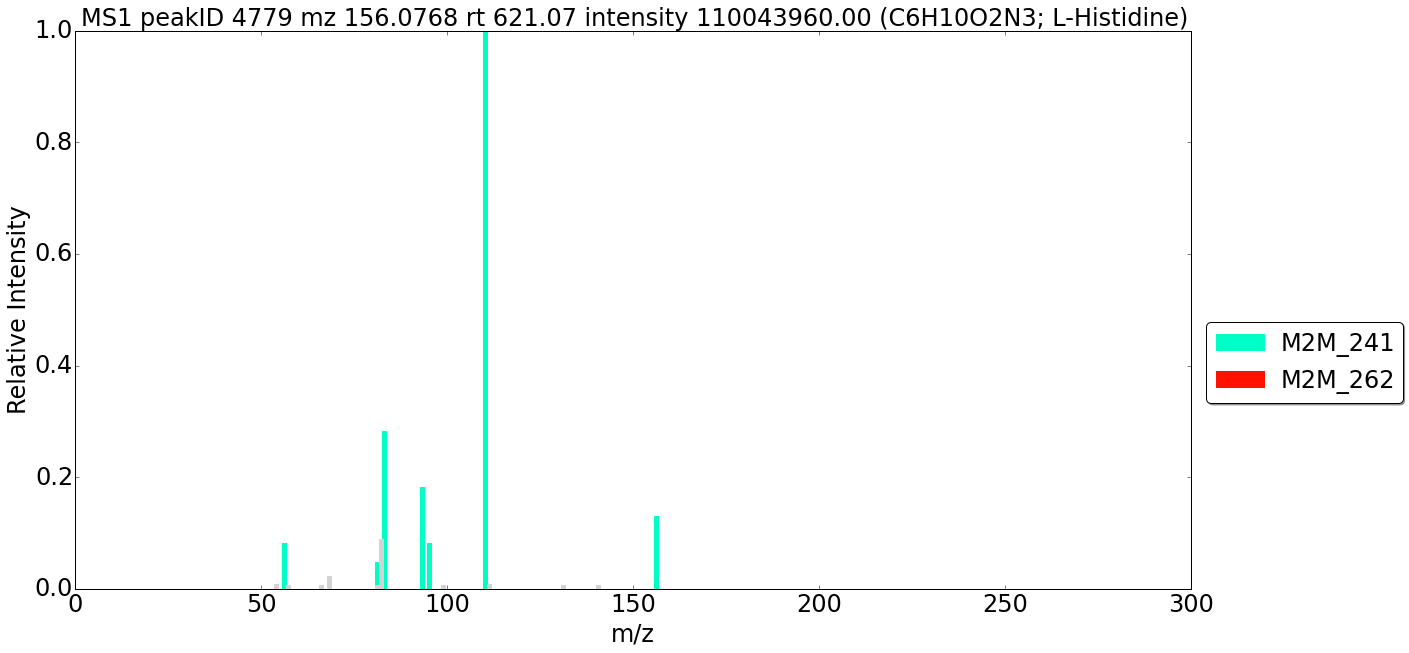

MS1 peakID 789 mz 116.0705 rt 577.27 intensity 2079356160.00 (C5H10O2N; L-Proline)
 - M2M_2	: Small nitrogen containing fragment ion - often proline or ornithine derived
 - M2M_262	: Combined loss of H2O and CO, suggests free carboxylic acid group (COOH) substructure



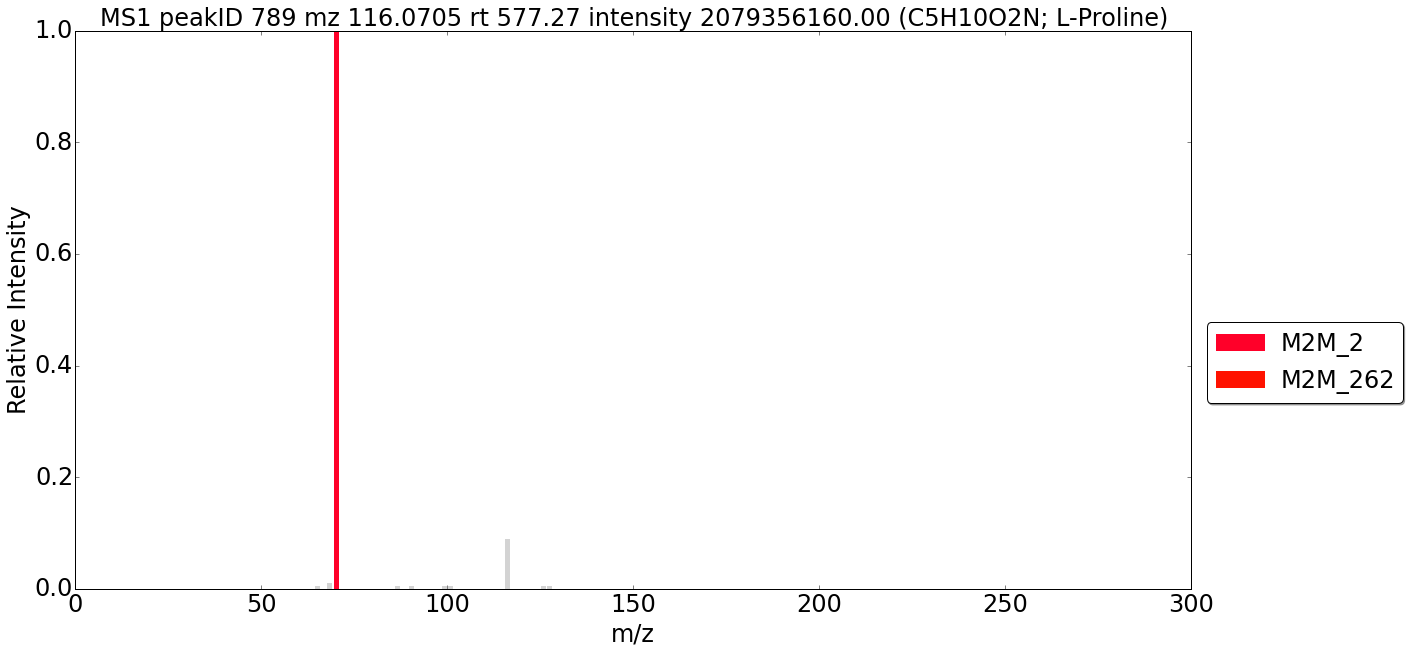

MS1 peakID 16867 mz 252.1089 rt 439.65 intensity 29635886.00 (C9H18O7N; Deoxyadenosine)
 - M2M_220	: Adenine substructure



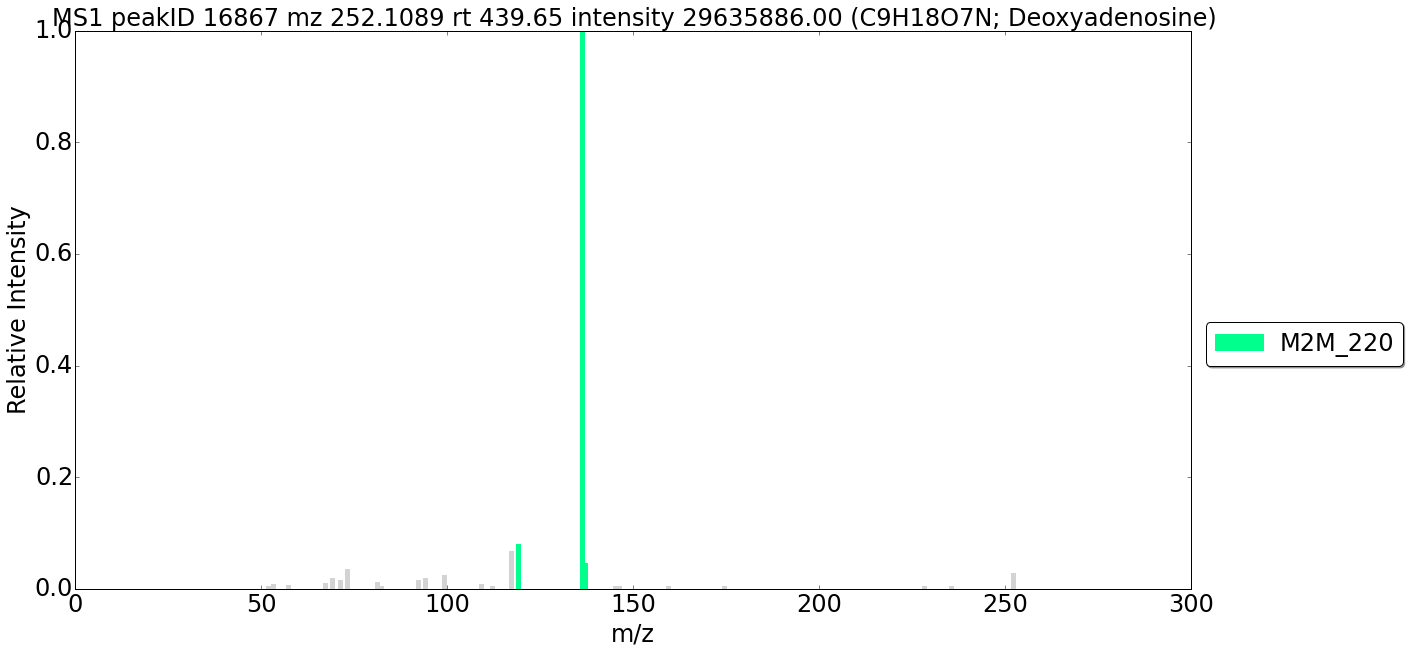

MS1 peakID 7113 mz 176.1030 rt 653.76 intensity 48279332.00 (C6H14O3N3; L-Citrulline)
 - M2M_2	: Small nitrogen containing fragment ion - often proline or ornithine derived
 - M2M_214	: Amine loss - suggests free NH2 group in fragmented molecule



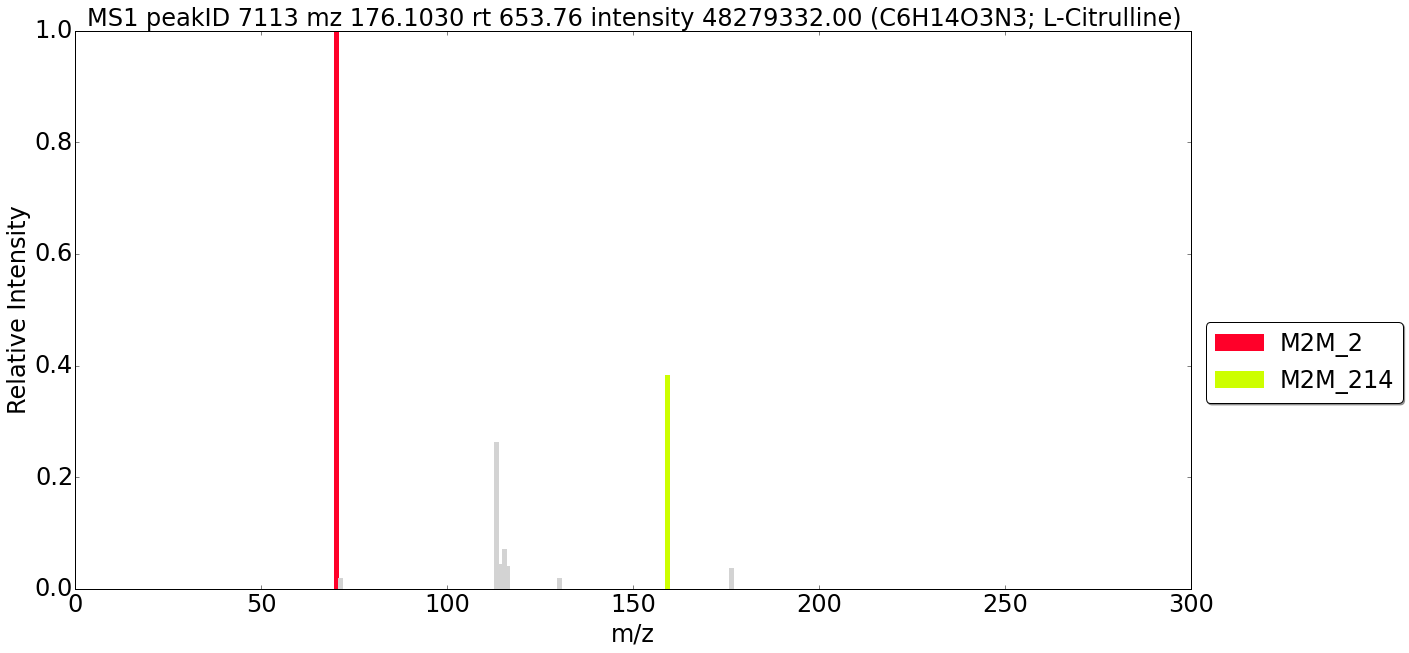

MS1 peakID 23395 mz 298.0968 rt 386.31 intensity 2876561.75 (C10H20O7NS; 5'-Methylthioadenosine)
 - M2M_220	: Adenine substructure



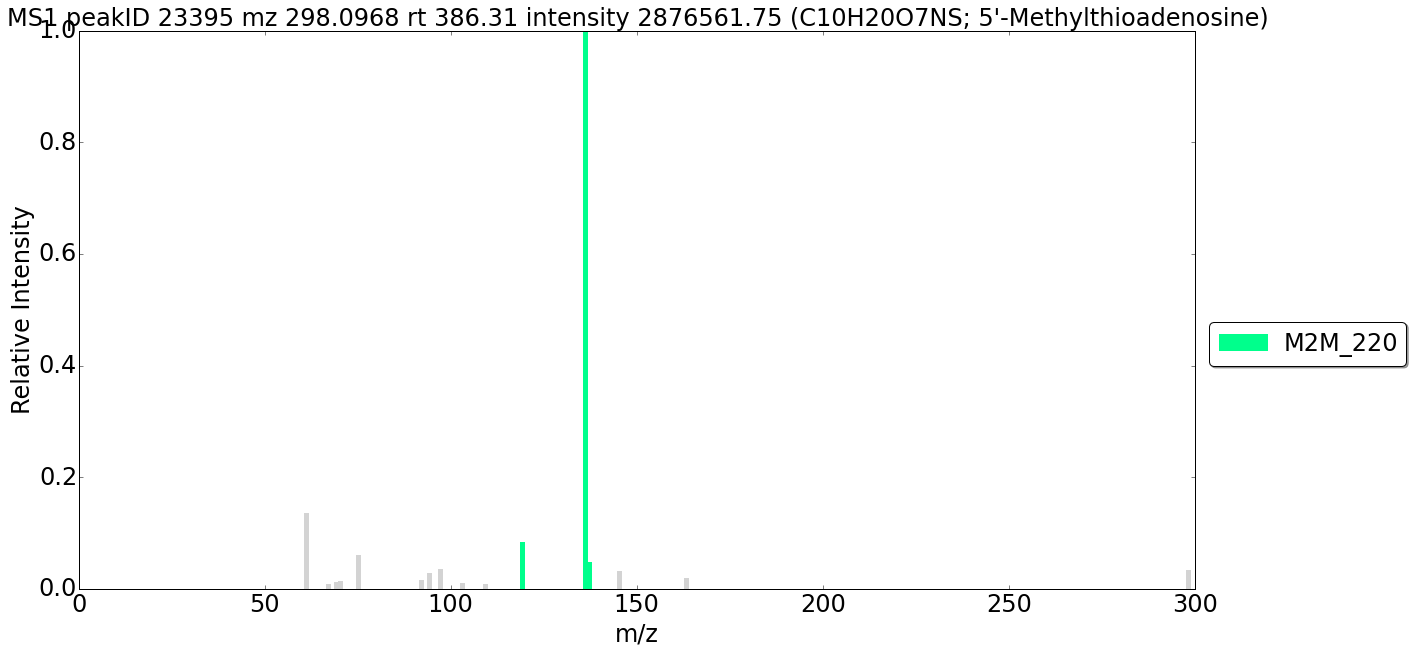

MS1 peakID 932 mz 118.0862 rt 531.06 intensity 1698129920.00 (C5H12O2N; Betaine)
 - M2M_280	: Loss possibly indicative of carboxylic acid group with 1-carbon attached
 - M2M_184	: Trimethylated amine connected to a carboxylic acid group substructure (e.g. betaine)
 - M2M_79	: Trimethylated amine connected to a carboxylic acid group substructure (e.g. betaine)



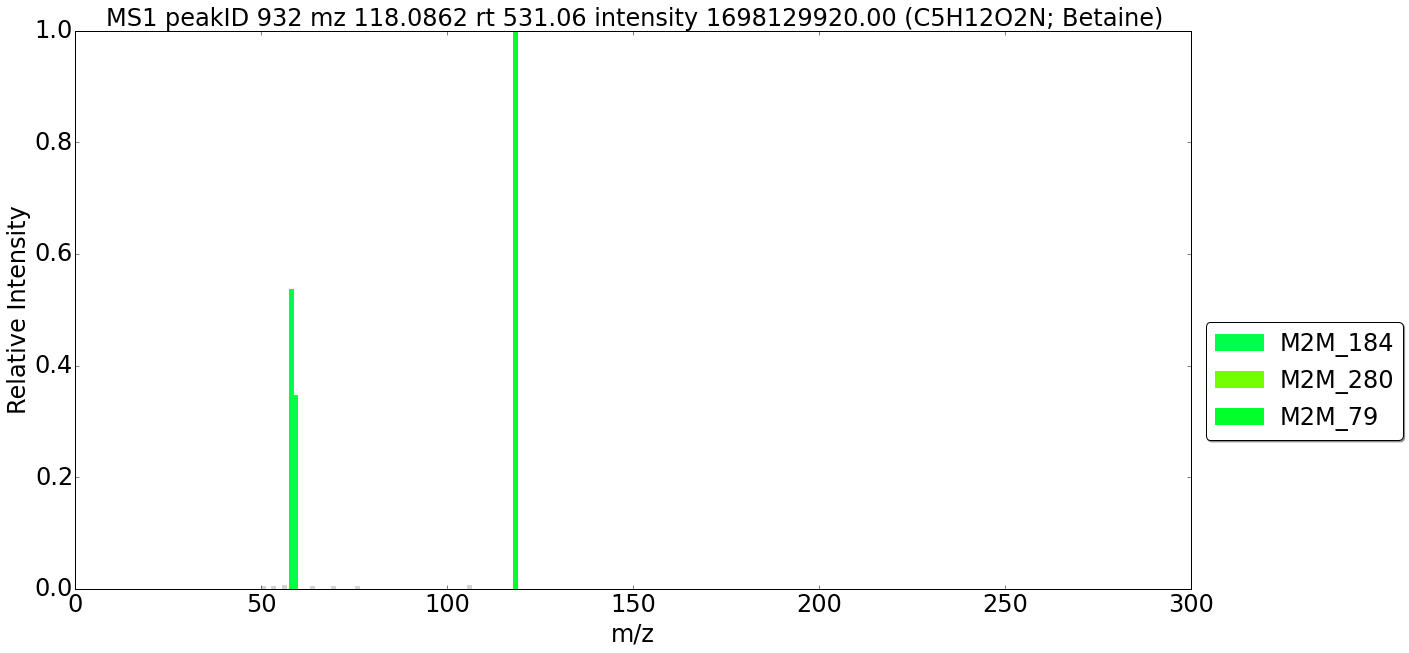

MS1 peakID 567 mz 112.0506 rt 550.96 intensity 19761036.00 (C4H6ON3; cytosine)
 - M2M_130	: Cytosine and a loss of conjugated deoxyribose substructure
 - M2M_214	: Amine loss - suggests free NH2 group in fragmented molecule



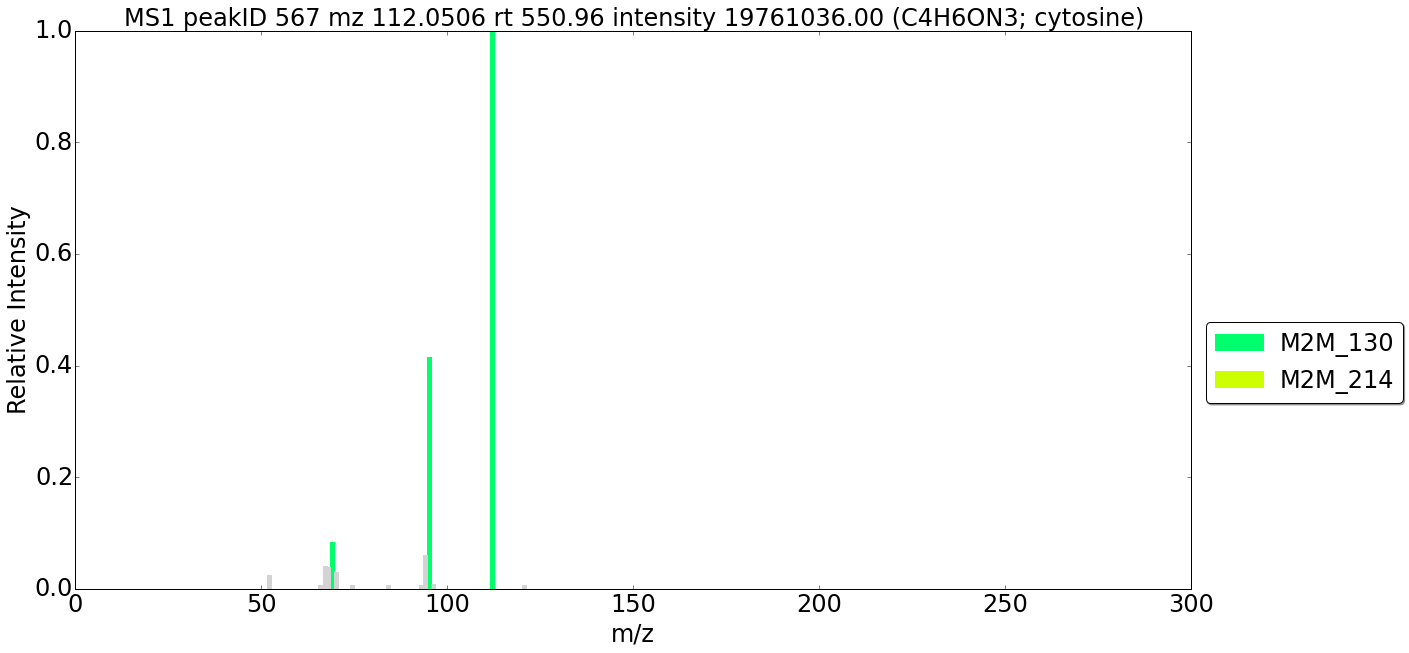

MS1 peakID 12331 mz 222.0972 rt 547.24 intensity 3724312.00 (C8H16O6N; N-Acetyl-D-glucosamine)
 - No M2M for this MS1 peak at the specified thresholding levels

MS1 peakID 30635 mz 377.1452 rt 452.14 intensity 1369326.12 (C13H27ON6P2S; riboflavin)
 - M2M_69	: Possibly suggests 2-OH-4-oxo-pentanoic acid substructure



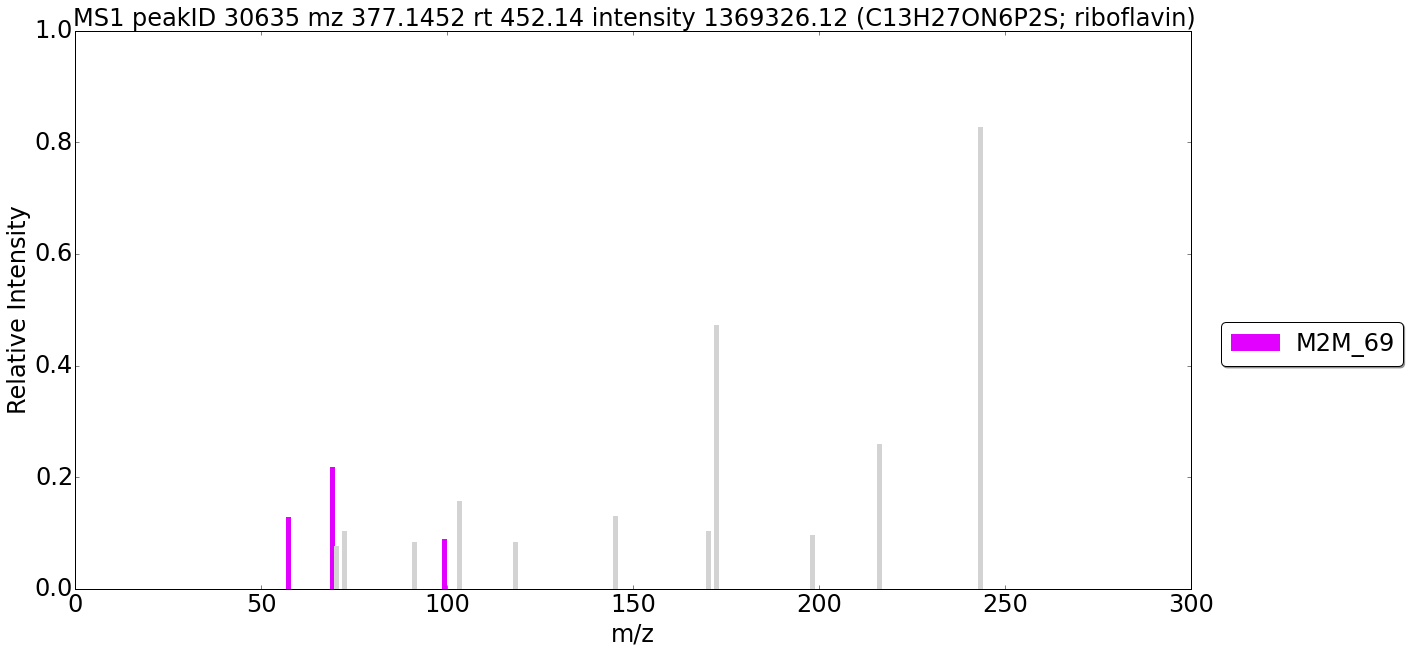

MS1 peakID 1414 mz 127.0501 rt 410.33 intensity 40250532.00 (C5H7O2N2; thymine)
 - M2M_214	: Amine loss - suggests free NH2 group in fragmented molecule



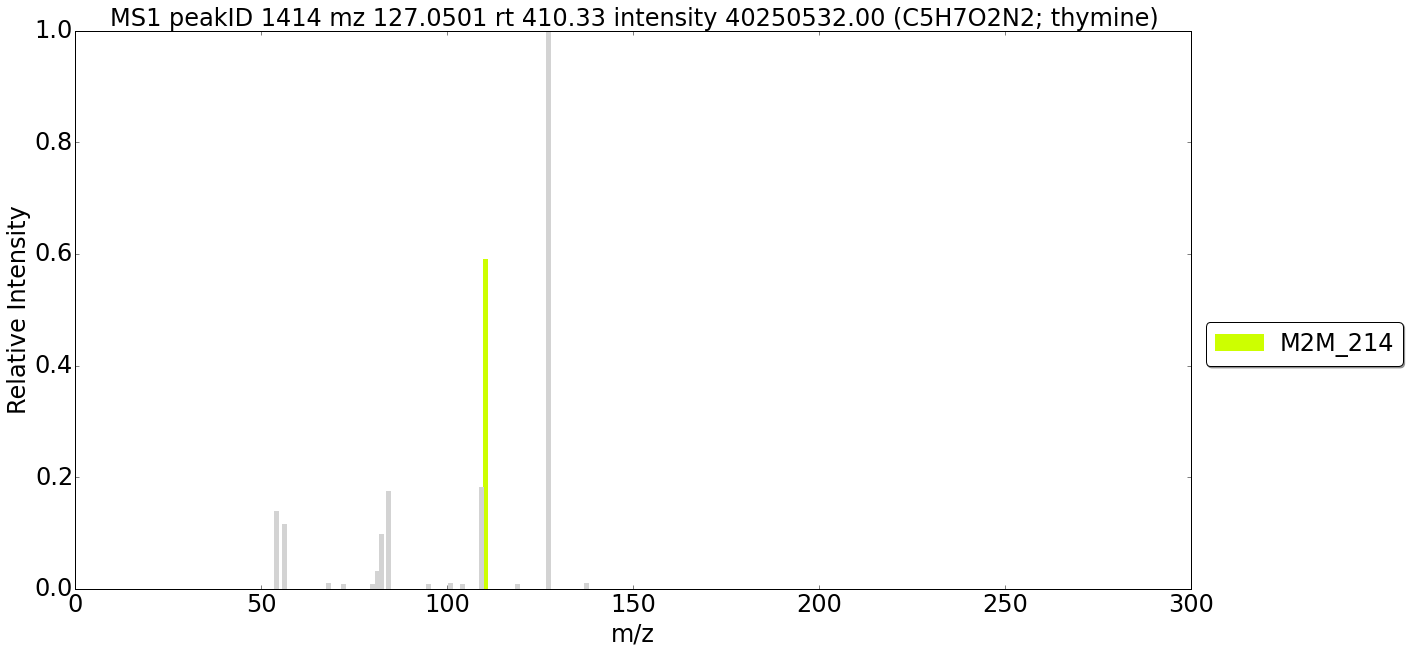

MS1 peakID 2511 mz 133.0607 rt 636.29 intensity 25519770.00 (C4H9O3N2; L-Asparagine)
 - M2M_42	: Asparagine substructure
 - M2M_211	: N-acetylputrescine substructure
 - M2M_262	: Combined loss of H2O and CO, suggests free carboxylic acid group (COOH) substructure



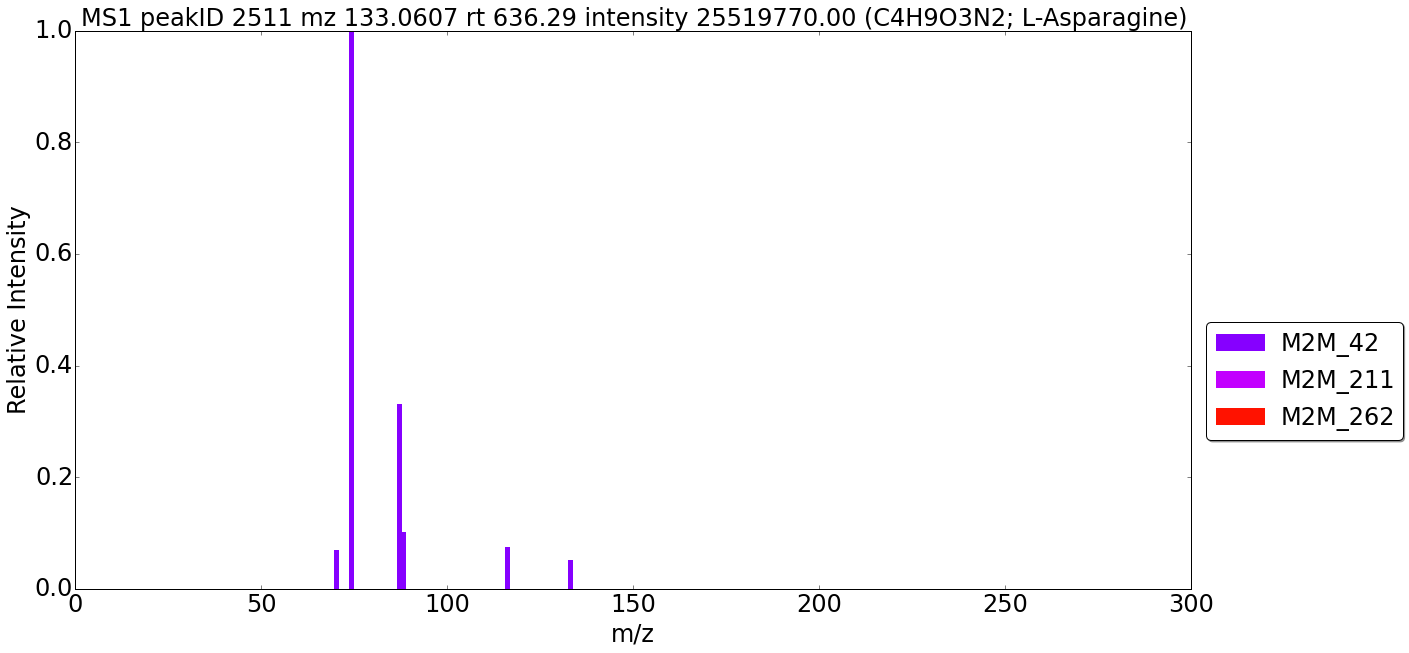

MS1 peakID 2254 mz 132.0655 rt 567.29 intensity 18472026.00 (C5H10O3N; 5-Aminolevulinate)
 - M2M_260	: Water loss - indicative of a free hydroxyl group
 - M2M_262	: Combined loss of H2O and CO, suggests free carboxylic acid group (COOH) substructure



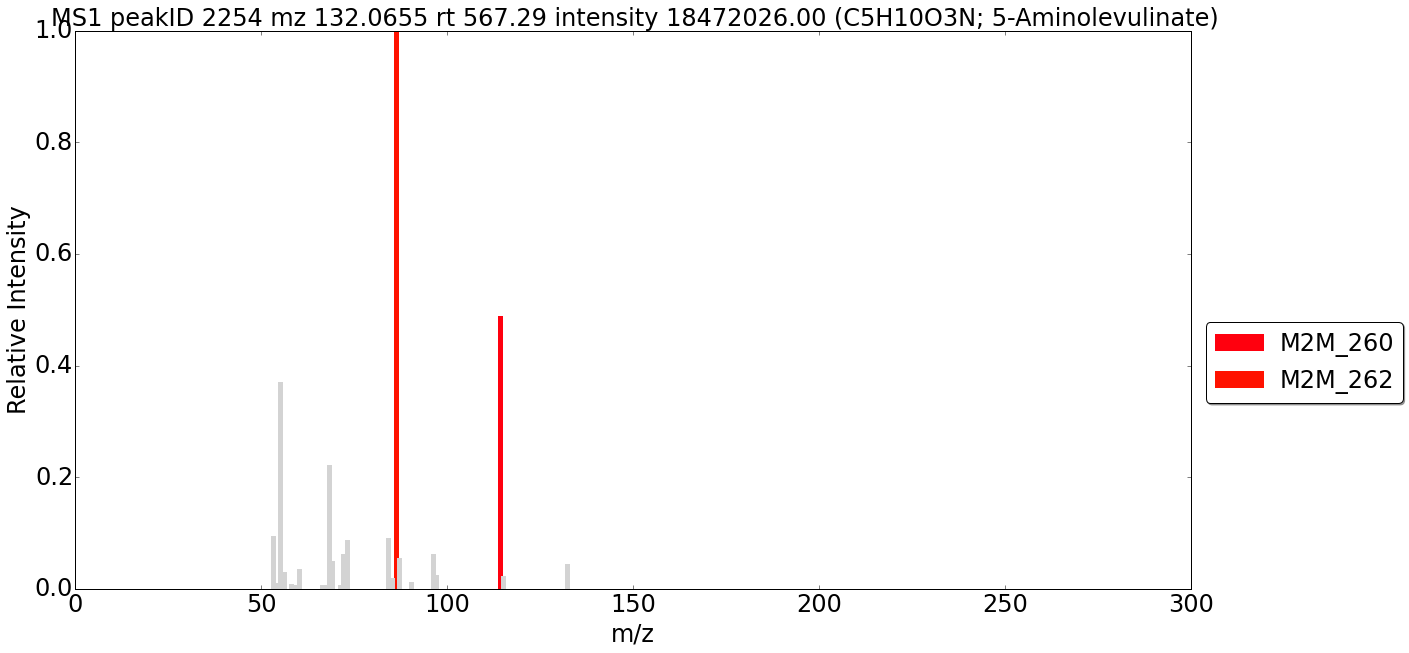

MS1 peakID 2632 mz 136.0618 rt 495.51 intensity 599815168.00 (C5H6N5; Adenine)
 - M2M_220	: Adenine substructure
 - M2M_214	: Amine loss - suggests free NH2 group in fragmented molecule



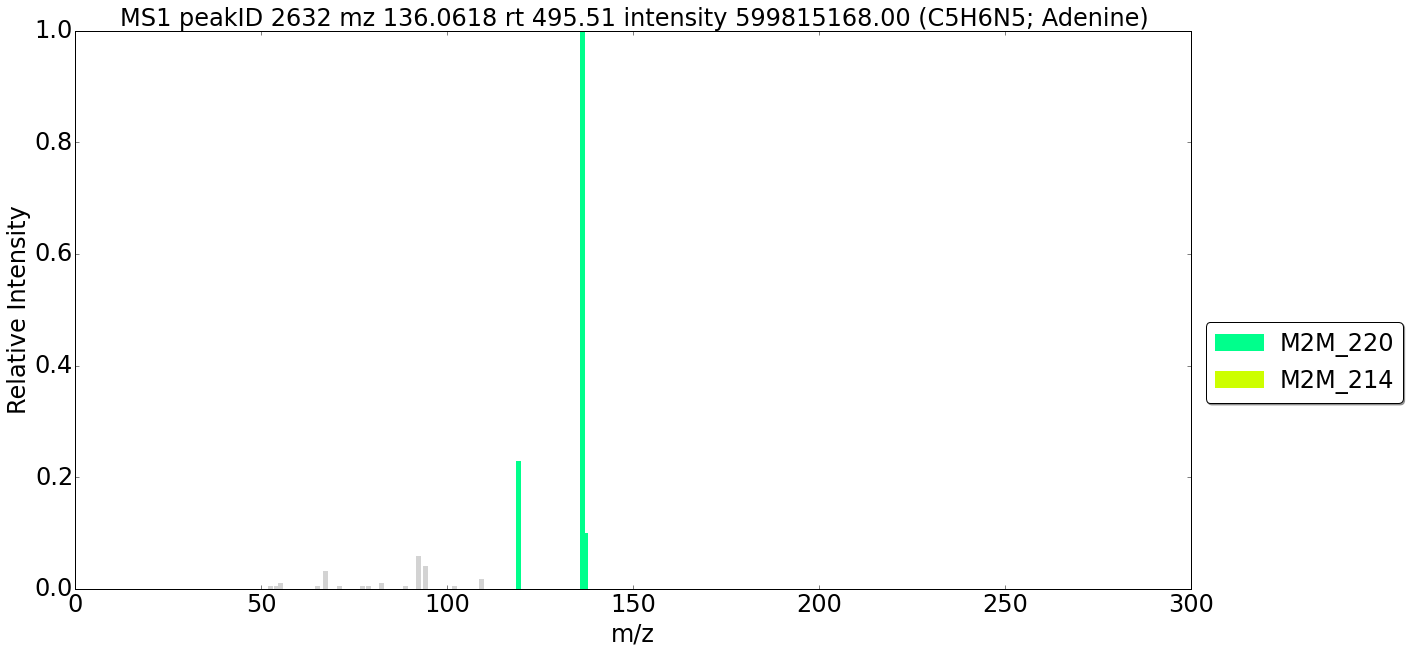

MS1 peakID 17496 mz 258.1099 rt 604.70 intensity 1099428992.00 (C11H20N3S2; sn-glycero-3-Phosphocholine)
 - No M2M for this MS1 peak at the specified thresholding levels

MS1 peakID 1226 mz 124.0393 rt 401.07 intensity 6944196.00 (C6H6O2N; Nicotinate)
 - No M2M for this MS1 peak at the specified thresholding levels

MS1 peakID 4103 mz 150.0584 rt 539.75 intensity 5108756.00 (C5H12O2NS; L-Methionine)
 - M2M_214	: Amine loss - suggests free NH2 group in fragmented molecule
 - M2M_262	: Combined loss of H2O and CO, suggests free carboxylic acid group (COOH) substructure



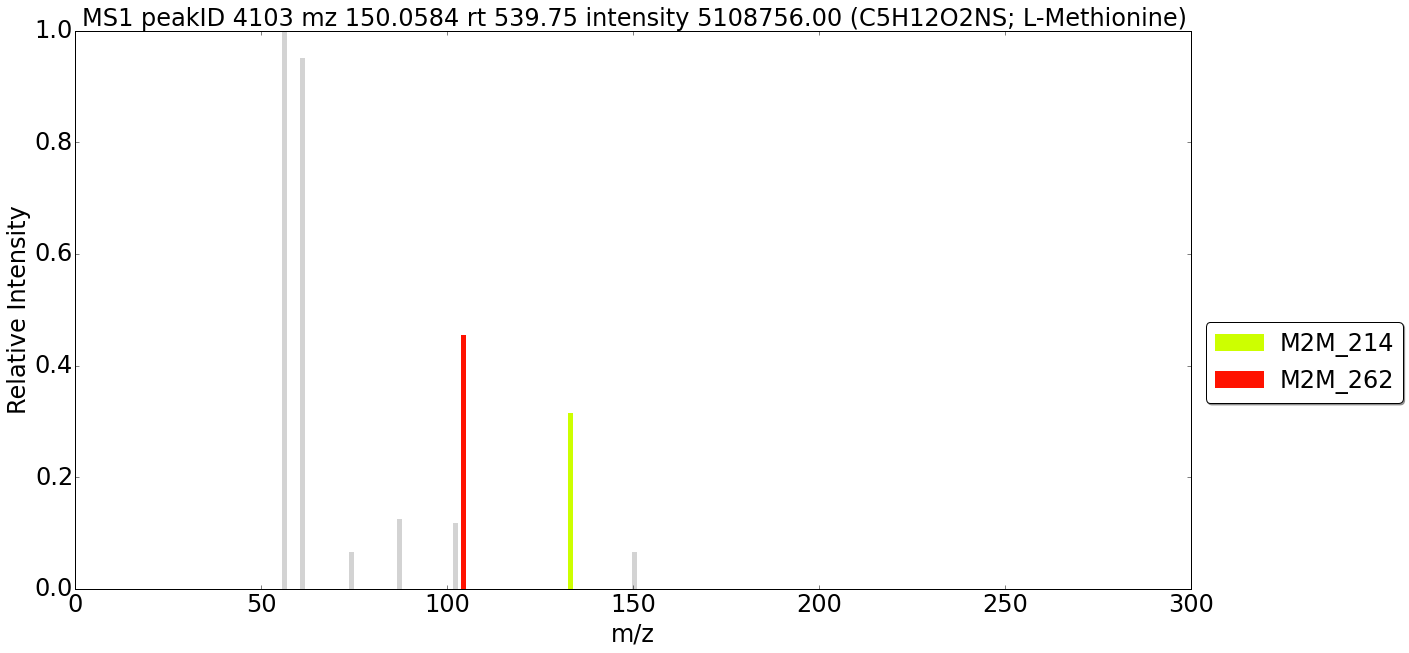

MS1 peakID 7901 mz 184.0733 rt 615.86 intensity 23100436.00 (C5H15O4NP; Choline phosphate)
 - M2M_243	: Conjugation of a phosphate group (H4O4P) substructure
 - M2M_158	: Leucine substructure



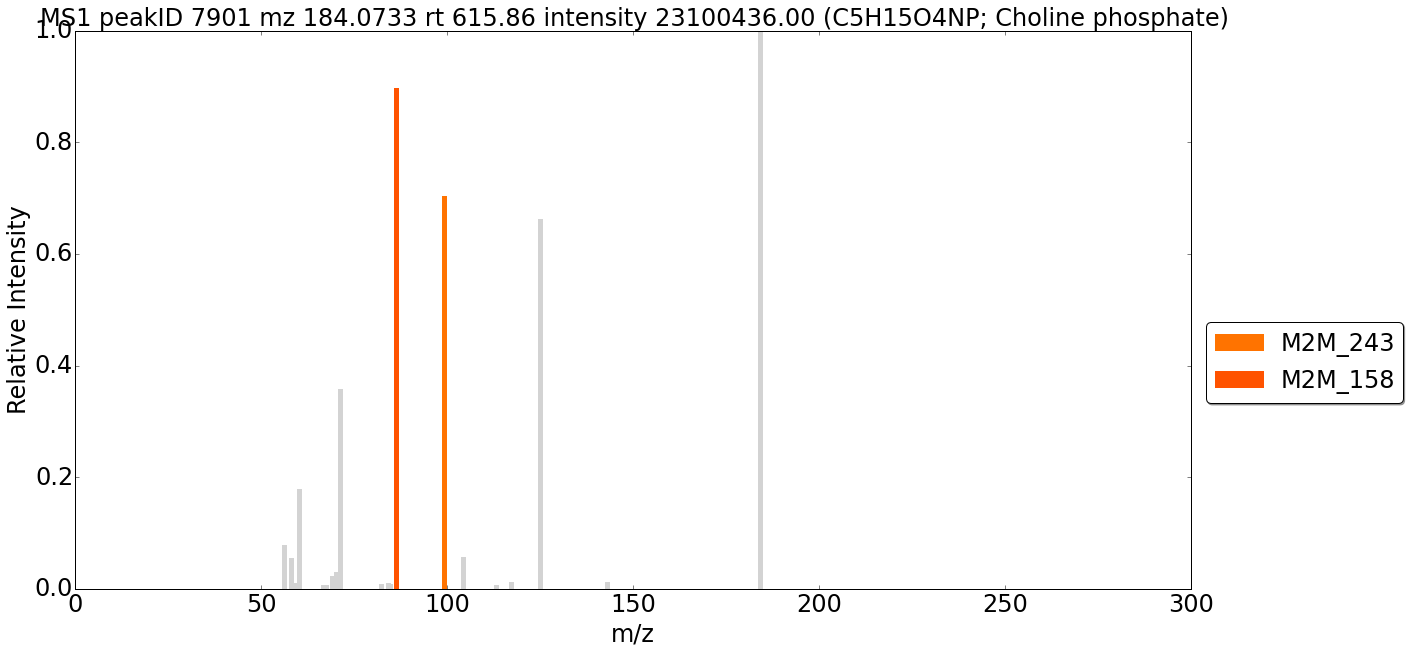

In [97]:
m2m_list = motifs_of_interest
for i in range(len(ms1_list)):
    
    ms1 = ms1_list[i]
    df = print_report(ms2lda, G, ms1, motif_annotation, motif_colour, motif_idx, word_map, 
                      ms1_label=ms1_label, xlim_upper=300)
    # display(df) # show the table to see the mz, annotations, etc